<center><h1>Saloni_Fnu_HW4</h1></center>
<br>
<br>

Name: Fnu Saloni
<br>
Github Username: fnusaloni
<br>
USC ID: 3175644840

## 1. Time Series Classification Part 1: Feature Creation/Extraction (HW3 Rerun)

### (a) Obtain Data

Import packages

In [58]:
import os
import pandas as pd
import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import statsmodels.api as sm
import warnings
from statsmodels.tools.sm_exceptions import PerfectSeparationWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning


from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline

from sklearn.utils import resample


from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFECV


from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import label_binarize

from scipy.interpolate import interp1d


Get the AReM Data Set

In [60]:
location = '../data/AReM'

def getData(location):
    # combining all the dataframes from different files into one
    return pd.concat([
        # opening and reading each file
        pd.read_csv(os.path.join(location, activityName, fileName), 
                    # skiiping forst 5 rows as it doesnot contain any data and giving names to each column properly
                    skiprows=5, header=None, 
                    names=['time', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23'], 
                    # since dataset4 of bending has the values in one colu only so using if for that else for rest dataset
                    sep=r"\s+" if (activityName == 'bending2') else ",",
                    on_bad_lines='skip')
        .assign(activityName=activityName)  
        # going through activity folders first
        for activityName in os.listdir(location) if os.path.isdir(os.path.join(location, activityName))
        # then going through csv files in each activity folder
        for fileName in os.listdir(os.path.join(location, activityName)) if fileName.startswith('dataset') and fileName.endswith('.csv')
    ], ignore_index=True)

dataRead = getData(location)
dataRead

time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0           0      42.00       0.00      18.50       0.50      12.00   
1         250      42.00       0.00      18.00       0.00      11.33   
2         500      42.75       0.43      16.75       1.79      18.25   
3         750      42.50       0.50      16.75       0.83      19.00   
4        1000      43.00       0.82      16.25       0.83      18.00   
...       ...        ...        ...        ...        ...        ...   
42232  118500      40.25       1.30      12.67       1.70      20.50   
42233  118750      41.75       1.79      11.00       6.00      16.67   
42234  119000      36.33       0.47      16.00       3.16      20.33   
42235  119250      31.50       1.50      21.00       0.00      12.25   
42236  119500      34.25       6.38      12.67       2.49      15.25   

       var_rss23 activityName  
0           0.00     bending1  
1           0.94     bending1  
2           0.43     bending1  
3           1.22     bending1  
4           0.00     bending1  
...          ...          ...  
42232       0.50      cycling  
42233       2.49      cycling  
42234       1.70      cycling  
42235       7.12      cycling  
42236       4.21      cycling  

[42237 rows x 8 columns]

### (b) Splitting Data

In [62]:
def splittingFunc(df, noSeg=1):
    # Calculating the length of each segment
    legSeg = len(df) // noSeg
    # Initializing an empty list to store split dataframes
    splitDs = []
    # Iterating through the number of segments
    for i in range(noSeg):
        dsSeg = df.iloc[i * legSeg:(i + 1) * legSeg].reset_index(drop=True)
        dsSeg = dsSeg.add_suffix(f"_{i+1}")
        splitDs.append(dsSeg)
    return pd.concat(splitDs, axis=1)


def featureExtract(df):

    # Defining a list of feature names for readability
    featureName = ['min', 'max', 'mean', 'median', 'std', '1st quart', '3rd quart']
    # Initializing an empty dictionary to store extracted features
    timeFeatures = {}
    # Iterating over each column in the DataFrame while assuming they represent different sensors
    for i, c in enumerate(df.columns):
        
        tracker_num = i + 1
        timeFeatures[f"min{tracker_num}"]      = df[c].min()
        timeFeatures[f"max{tracker_num}"]      = df[c].max()
        timeFeatures[f"mean{tracker_num}"]     = df[c].mean()
        timeFeatures[f"median{tracker_num}"]   = df[c].median()
        timeFeatures[f"std{tracker_num}"]      = df[c].std()
        timeFeatures[f"1st quart{tracker_num}"] = df[c].quantile(0.25)
        timeFeatures[f"3rd quart{tracker_num}"] = df[c].quantile(0.75)
    return pd.DataFrame([timeFeatures])


def trainTestData(homePath, noSeg=1):
 
    # Initializing lists for storing train and test dataframes and labels
    testDs = []
    trainDs = []
    testHd = []
    trainHd = []
    
    # Looping through each folder in the base directory
    for fol in sorted(os.listdir(homePath)):
        fol_path = os.path.join(homePath, fol)
        
        # Skipping if the path is not a directory
        if not os.path.isdir(fol_path):
            continue
        
        # Setting the test file names based on the folder type
        if fol.lower() in ['bending1', 'bending2']:
            testFile = {'dataset1.csv', 'dataset2.csv'}
        else:
            testFile = {'dataset1.csv', 'dataset2.csv', 'dataset3.csv'}
        
        # Looping through each file in the folder
        for fileName in sorted(os.listdir(fol_path)):
            # Checking if the file is a CSV and follows the naming pattern
            if fileName.endswith('.csv') and fileName.startswith('dataset'):
                wholePath = os.path.join(fol_path, fileName)
                
                # Determining the correct separator (handling space for specific cases)
                if fol.lower() == 'bending2' and fileName == 'dataset4.csv':
                    sep = r"\s+"
                else:
                    sep = ","
                
                # Attempting to read the CSV file while skipping bad lines
                try:
                    df = pd.read_csv(
                        wholePath, 
                        sep=sep, 
                        skiprows=5, 
                        header=None,
                        names=["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"],
                        on_bad_lines='skip'
                    )
                except Exception as e:
                    # Printing an error message if file reading fails
                    print(f"Error reading {wholePath}: {e}")
                    continue
                
                # Selecting only the six relevant columns (excluding time)
                df = df[["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]]
                
                
                if noSeg > 1:
                    df = splittingFunc(df, noSeg)
                
                # Extracting features from the (possibly segmented) data
                timeFeatures_df = featureExtract(df)
                
                # Defining the label: assigning 1 if the folder name contains 'bending', otherwise 0
                labelName = 1 if "bending" in fol.lower() else 0
                
                # Assigning the file to the test or train set based on its name
                if fileName in testFile:
                    testDs.append(timeFeatures_df)
                    testHd.append(labelName)
                else:
                    trainDs.append(timeFeatures_df)
                    trainHd.append(labelName)

    # Combining all extracted feature dataframes for training and testing
    trainDs = pd.concat(trainDs, ignore_index=True) if trainDs else pd.DataFrame()
    testDs = pd.concat(testDs, ignore_index=True) if testDs else pd.DataFrame()
    
    # Returning the processed train and test datasets along with their labels
    return trainDs, testDs, trainHd, testHd



homePath = '../data/AReM'  
noSeg = 1  


trainDs, testDs, trainHd, testHd = trainTestData(homePath, noSeg)


combined_df = pd.concat([trainDs, testDs], ignore_index=True)
combined_labels = trainHd + testHd


combined_df['Label'] = combined_labels


print(combined_df.head())  


    min1   max1      mean1  median1      std1  1st quart1  3rd quart1  min2  \
0  35.00  47.40  43.954500    44.33  1.558835       43.00       45.00   0.0   
1  33.00  47.75  42.179812    43.50  3.670666       39.15       45.00   0.0   
2  33.00  45.75  41.678063    41.75  2.243490       41.33       42.75   0.0   
3  37.00  48.00  43.454958    43.25  1.386098       42.50       45.00   0.0   
4  36.25  48.00  43.969125    44.50  1.618364       43.31       44.67   0.0   

   max2     mean2  ...  1st quart5  3rd quart5  min6  max6     mean6  median6  \
0  1.70  0.426250  ...     35.3625       36.50   0.0  1.79  0.493292     0.43   
1  3.00  0.696042  ...     30.4575       36.33   0.0  2.18  0.613521     0.50   
2  2.83  0.535979  ...     28.4575       31.25   0.0  1.79  0.383292     0.43   
3  1.58  0.378083  ...     22.2500       24.00   0.0  5.26  0.679646     0.50   
4  1.50  0.413125  ...     20.5000       23.75   0.0  2.96  0.555312     0.49   

       std6  1st quart6  3rd quart6  L

### (c) Feature Extraction

In [64]:
if __name__ == '__main__':
    
    homePath = '../data/AReM'
    numSeg = 1  

    
    trainSet, testSet, trainTag, testTag = trainTestData(homePath, numSeg)

    
    comData = pd.concat([trainSet, testSet], ignore_index=True)
    
    
    comTag = list(trainTag)
    comTag.extend(testTag)

    
    comData['ActivityLabel'] = comTag

    
    print(trainSet)  


     min1   max1      mean1  median1      std1  1st quart1  3rd quart1  min2  \
0   35.00  47.40  43.954500   44.330  1.558835       43.00     45.0000   0.0   
1   33.00  47.75  42.179812   43.500  3.670666       39.15     45.0000   0.0   
2   33.00  45.75  41.678063   41.750  2.243490       41.33     42.7500   0.0   
3   37.00  48.00  43.454958   43.250  1.386098       42.50     45.0000   0.0   
4   36.25  48.00  43.969125   44.500  1.618364       43.31     44.6700   0.0   
..    ...    ...        ...      ...       ...         ...         ...   ...   
64  20.75  46.25  34.763333   35.290  4.742208       31.67     38.2500   0.0   
65  21.50  51.00  34.935812   35.500  4.645944       32.00     38.0625   0.0   
66  18.33  47.67  34.333042   34.750  4.948770       31.25     38.0000   0.0   
67  18.33  45.75  34.599875   35.125  4.731790       31.50     38.0000   0.0   
68  15.50  43.67  34.225875   34.750  4.441798       31.25     37.2500   0.0   

     max2     mean2  ...      std5  1st

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

### (a) Binary Classification Using Logistic Regression

#### i. Plots

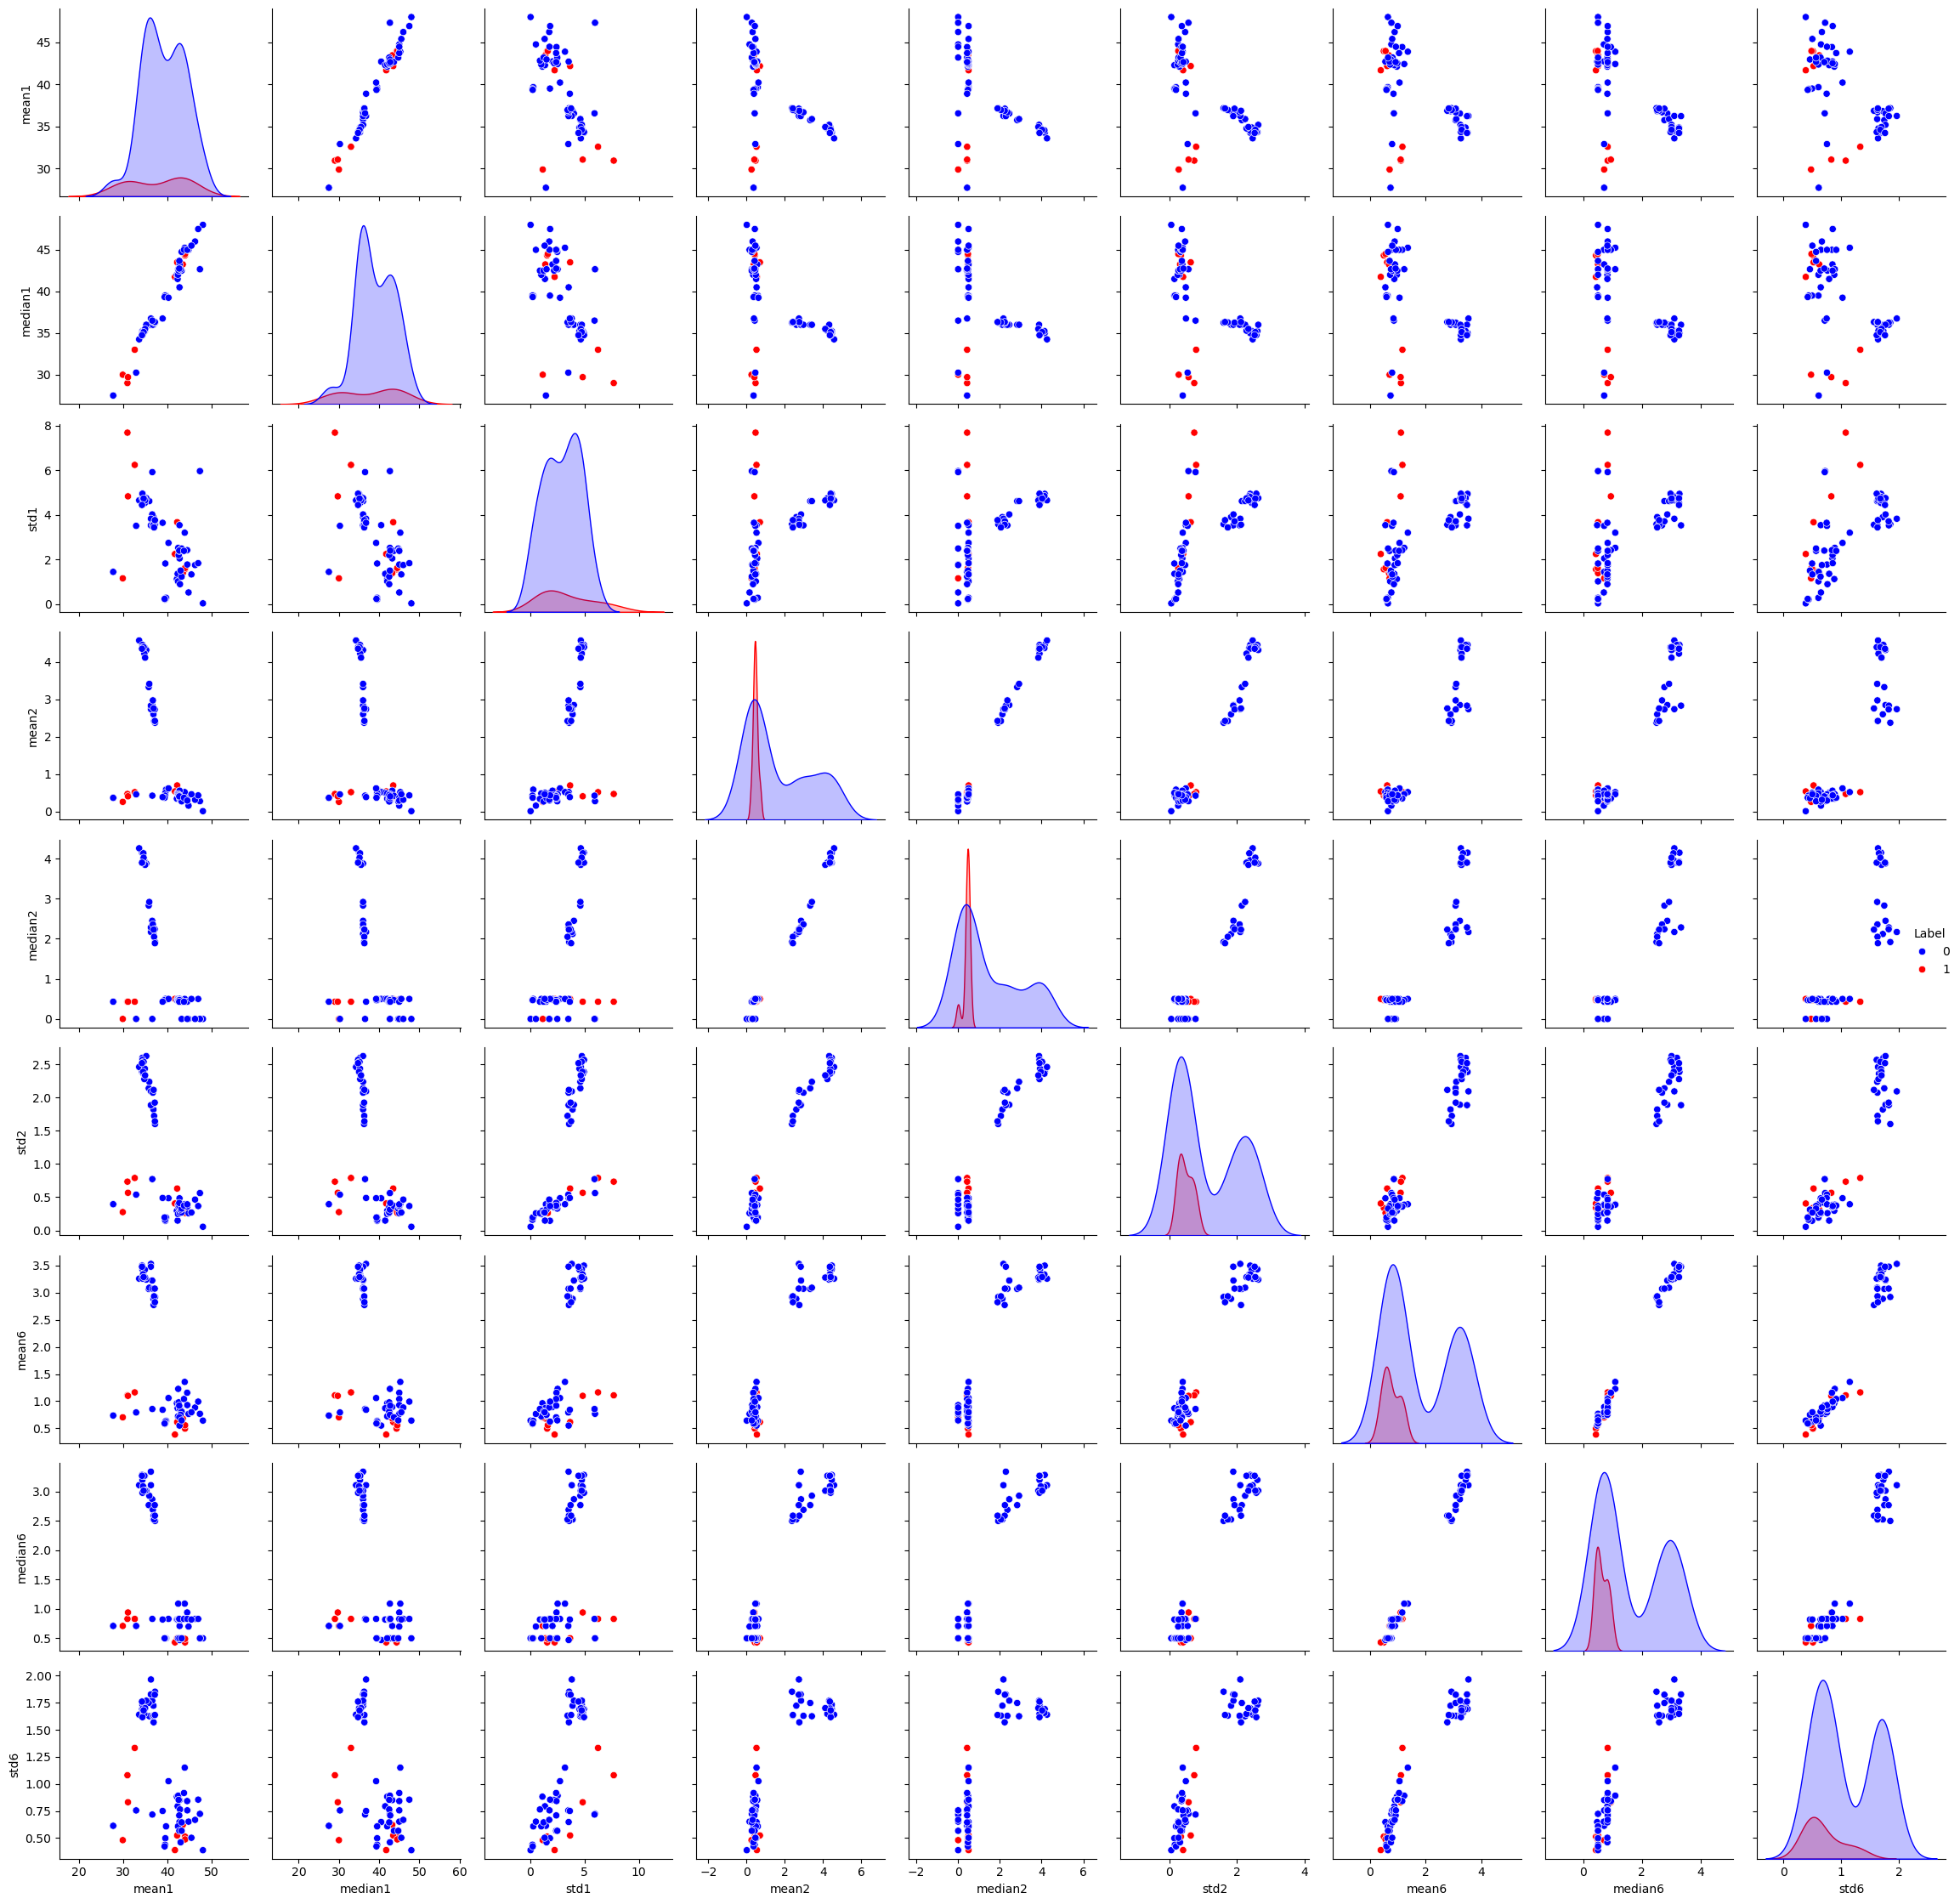

In [69]:
# Creating a list of feature names for time series 1, 2, and 6
timeFeatures = [f"{tfeat}{ts}" for ts in [1, 2, 6] for tfeat in ['mean', 'median', 'std']]

# Building a new DataFrame for plotting using training data (trainSet) and labels (trainTag)
plotTrain = trainSet[timeFeatures].copy()

# Adding the labels to the DataFrame for classification visualization
plotTrain['Label'] = trainTag

sns.pairplot(data=plotTrain, hue='Label', palette={1: 'red', 0: 'blue'})


plt.tight_layout()

# Displaying the plot
plt.show()  


#### ii. Splitted Plots

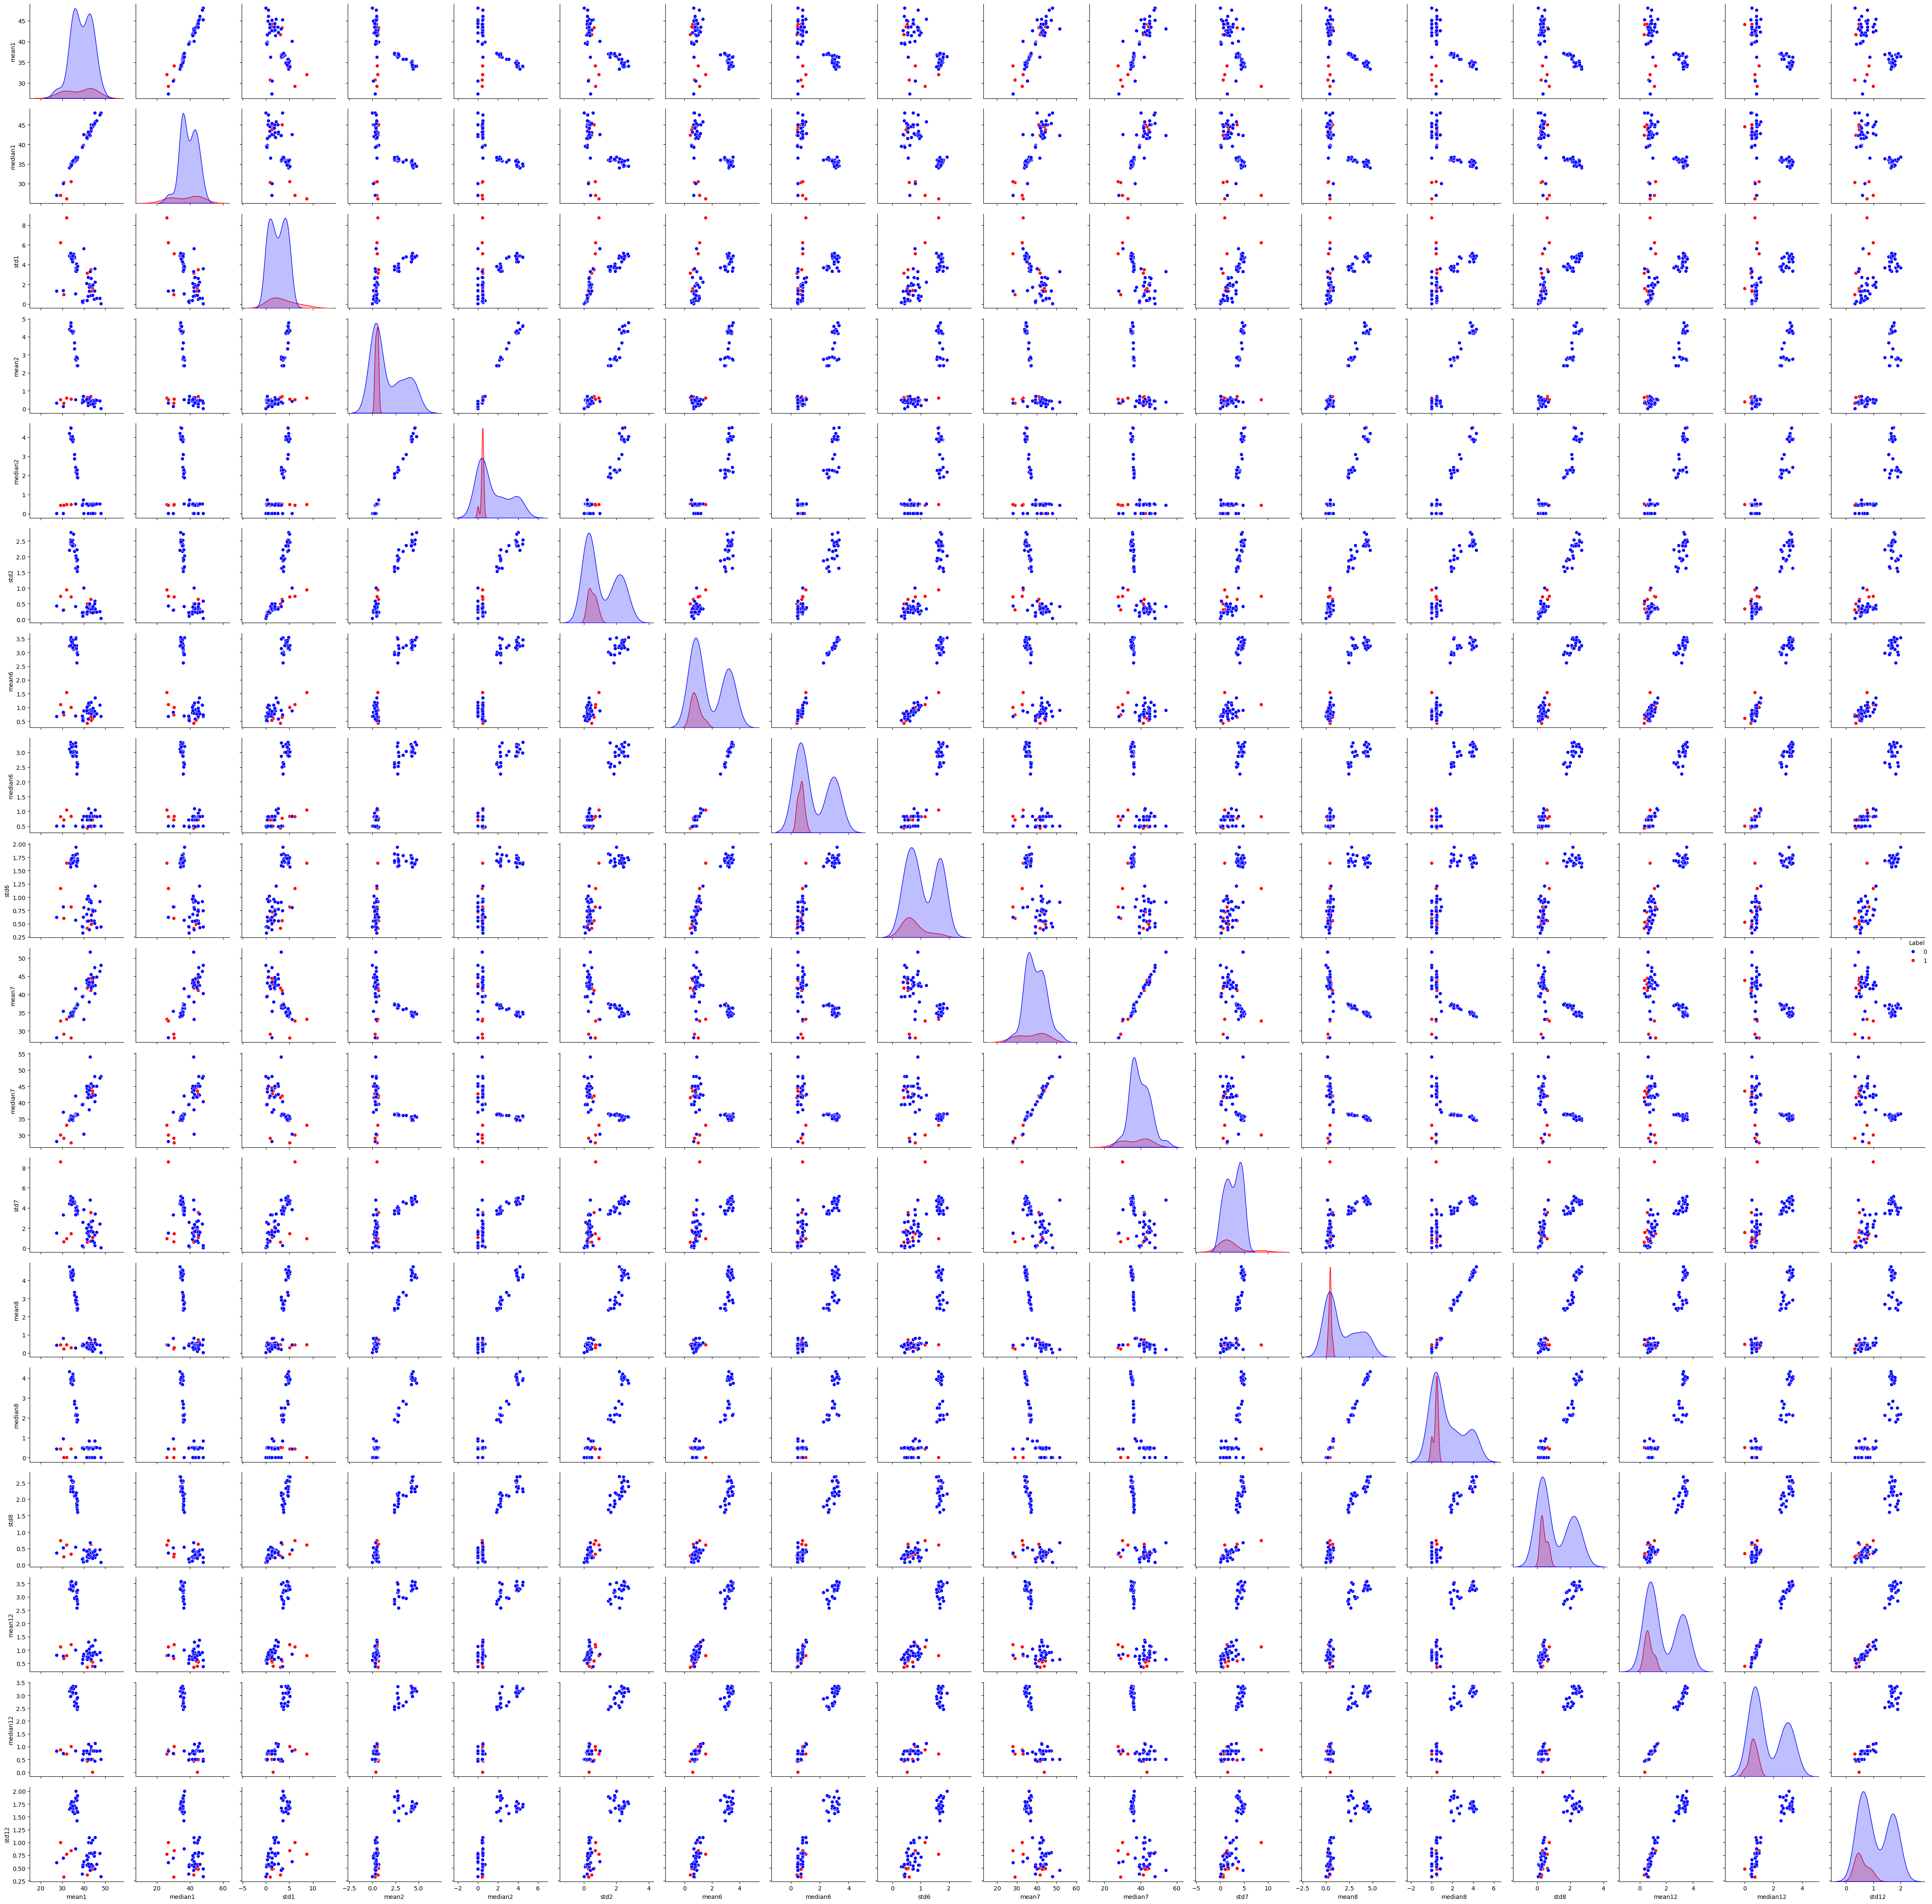

In [71]:
# setting the number of segments to 2 so that additional columns like "mean7" appear
noSeg = 2  

# creating train and test datasets along with their labels
trainDs, testDs, trainHd, testHd = trainTestData(homePath, noSeg)

# initializing an empty list to store selected feature names
selectedTimeFeatures = []

# looping through specific sensor numbers and extracting mean, median, and std features
for tracker in [1, 2, 6]:
    for tfeat in ['mean', 'median', 'std']:
        selectedTimeFeatures.append(f"{tfeat}{tracker}")

# defining a mapping from original sensor numbers to column indices in segment 2
secSeg = {1: 7, 2: 8, 6: 12}  

# adding corresponding features from segment 2 to the selected features list
for tracker in [1, 2, 6]:
    for tfeat in ['mean', 'median', 'std']:
        selectedTimeFeatures.append(f"{tfeat}{secSeg[tracker]}")


plotTrain = trainDs[selectedTimeFeatures].copy()
plotTrain['Label'] = trainHd


sns.pairplot(data=plotTrain, hue='Label', palette={1: 'red', 0: 'blue'})


plt.tight_layout()

# displaying the plot
plt.show()


#### iii. Time Series Segments

In [73]:

homePath = '../data/AReM'


findings = []

# defining the number of folds for cross-validation
foldCount = 5


for segCnt in range(1, 21):
    
    # loading the training and testing data for the current segmentation level
    trainDt, testDt, trainHd, testHd = trainTestData(homePath, segCnt)
    
    
    feaCol = [c for c in trainDt.columns 
                    if 'mean' in c or 'median' in c or 'standard deviation' in c]
    
    # extracting the selected features from the training data
    X_train = trainDt[feaCol]
    
    
    y_train = trainHd
    
    # initializing a SimpleImputer to replace missing values with the mean of each column
    filler = SimpleImputer(strategy='mean')
    
    # defining a logistic regression model with L2 regularization
    mainModel = LogisticRegression(penalty='l2', C=1e12, max_iter=500)
    
    
    tFeatLimit = max(1, X_train.shape[1] // 2)
    rfeModel = RFE(estimator=mainModel, n_features_to_select=tFeatLimit)
    
    # creating a pipeline that first imputes missing values and then applies RFE
    pipeline = Pipeline(steps=[
        ('filler', filler),
        ('rfe', rfeModel)
    ])
    
    # defining a stratified 5-fold cross-validation to handle potential class imbalance
    stratKf = StratifiedKFold(n_splits=foldCount, shuffle=True, random_state=42)
    
    # evaluating the pipeline using cross-validation and computing the mean accuracy
    cvScor = cross_val_score(pipeline, X_train, y_train, cv=stratKf, scoring='accuracy')
    avgScor = np.mean(cvScor)
    
    # saving the segmentation count, selected features, and mean cross-validation accuracy
    findings.append((segCnt, tFeatLimit, avgScor))
    
    
    print(f"L = {segCnt}, P = {tFeatLimit}, "
          f" Accuracy = {avgScor:.4f}")

# converting results into a DataFrame for further analysis
evaluationDs = pd.DataFrame(findings, columns=['L', 'P ', 'Accuracy'])

# printing the summary of results
print("\nResults:")
print(evaluationDs)


L = 1, P = 6,  Accuracy = 0.9121
L = 2, P = 12,  Accuracy = 0.9560
L = 3, P = 18,  Accuracy = 0.9275
L = 4, P = 24,  Accuracy = 0.9275
L = 5, P = 30,  Accuracy = 0.9418
L = 6, P = 36,  Accuracy = 0.9560
L = 7, P = 42,  Accuracy = 0.9418
L = 8, P = 48,  Accuracy = 0.9560
L = 9, P = 54,  Accuracy = 0.9560
L = 10, P = 60,  Accuracy = 0.9703
L = 11, P = 66,  Accuracy = 0.9857
L = 12, P = 72,  Accuracy = 0.9714
L = 13, P = 78,  Accuracy = 0.9560
L = 14, P = 84,  Accuracy = 0.9714
L = 15, P = 90,  Accuracy = 0.9857
L = 16, P = 96,  Accuracy = 0.9560
L = 17, P = 102,  Accuracy = 0.9703
L = 18, P = 108,  Accuracy = 0.9560
L = 19, P = 114,  Accuracy = 0.9560
L = 20, P = 120,  Accuracy = 0.9560

Results:
     L   P   Accuracy
0    1    6  0.912088
1    2   12  0.956044
2    3   18  0.927473
3    4   24  0.927473
4    5   30  0.941758
5    6   36  0.956044
6    7   42  0.941758
7    8   48  0.956044
8    9   54  0.956044
9   10   60  0.970330
10  11   66  0.985714
11  12   72  0.971429
12  13   7

Getting highest accuracy of 0.985714 at L : 11

#### iv. Confusion Matrix

At segmentation level L = 5, total Features = 90, selected P = 45

Confusion Matrix:
[[60  0]
 [ 0  9]]
Training Accuracy: 1.0000


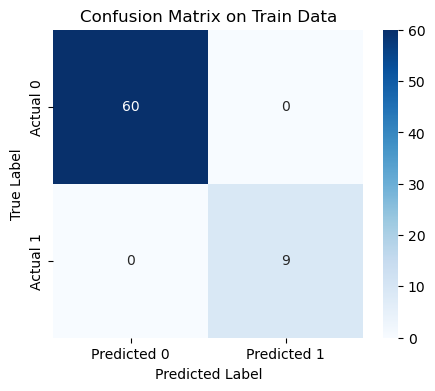

ROC AUC: 1.0000


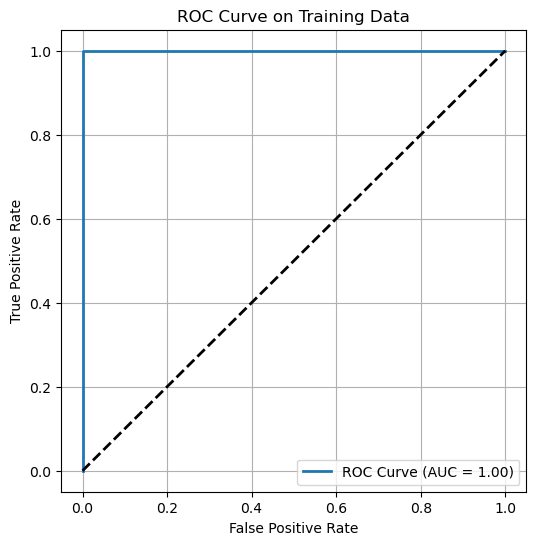


Logistic Regression Summary:
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       24
Method:                           MLE   Df Model:                           44
Date:                Fri, 07 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        23:17:33   Log-Likelihood:            -4.1899e-05
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                    0.1558
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1             -3.0621    8.3e+07  -3.69e-08      1.000   -1.63e+08    1.63e+08
2              7.0157        nan        nan        nan         nan         nan
3             -1.4976 

In [76]:


# suppressing warnings related to perfect separation and convergence issues
warnings.simplefilter('ignore', PerfectSeparationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)


homePath = '../data/AReM'

# assuming the best segmentation level is determined to be 5
foldC = 5


X_trainAll, X_testAll, y_trainAll, y_testAll = trainTestData(homePath, foldC)


timeCols = [c for c in X_trainAll.columns if ('mean' in c or 'median' in c or 'std' in c)]
X_train = X_trainAll[timeCols]
y_train = y_trainAll

# imputing missing values using the mean strategy
filler = SimpleImputer(strategy='mean')
X_trainImp = filler.fit_transform(X_train)

# defining logistic regression model with l2 regularization
baseLr = LogisticRegression(penalty='l2', C=1e12, max_iter=500)

# selecting half of the available features using rfe
num_timeFeatures_selected = max(1, X_train.shape[1] // 2)
rfeModel = RFE(estimator=baseLr, n_features_to_select=num_timeFeatures_selected)
X_trainSub = rfeModel.fit_transform(X_trainImp, y_train)

# printing details about segmentation level and selected features
print(f"At segmentation level L = {foldC}, total Features = {X_train.shape[1]}, selected P = {num_timeFeatures_selected}")

# adding a constant term and converting to dataframe for adjustments
X_trainSm = sm.add_constant(X_trainSub)
X_trainSmDs = pd.DataFrame(X_trainSm)


# removing any constant columns 
noConst = X_trainSmDs.loc[:, X_trainSmDs.apply(pd.Series.nunique) > 1]
X_trainSmDs = noConst.copy()


nowRank = np.linalg.matrix_rank(X_trainSmDs.values)
while nowRank < X_trainSmDs.shape[1]:
    X_trainSmDs = X_trainSmDs.iloc[:, :-1]
    nowRank = np.linalg.matrix_rank(X_trainSmDs.values)


# storing final selected column names
finCol = X_trainSmDs.columns

# fitting logistic regression using statsmodels
logMod = sm.Logit(y_train, X_trainSmDs).fit(disp=False)


# predicting probabilities on training data
y_trainPreProb = logMod.predict(X_trainSmDs)

# converting probabilities to binary predictions using a threshold of 0.5
y_trainPred = (y_trainPreProb >= 0.5).astype(int)

# computing confusion matrix
confMat = confusion_matrix(y_train, y_trainPred)

# computing training accuracy
accur = accuracy_score(y_train, y_trainPred)

# printing confusion matrix and training accuracy
print("\nConfusion Matrix:")
print(confMat)
print(f"Training Accuracy: {accur:.4f}")


# creating a dataframe for better labeling of confusion matrix
confMatDs = pd.DataFrame(confMat, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])


plt.figure(figsize=(5,4))
sns.heatmap(confMatDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Train Data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


# computing false positive rate, true positive rate, and thresholds for roc curve
fpr, tpr, thresholds = roc_curve(y_train, y_trainPreProb)

# computing area under the curve (auc)
rocAuc = auc(fpr, tpr)

# printing roc auc score
print(f"ROC AUC: {rocAuc:.4f}")


plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {rocAuc:.2f})', lw=2)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Training Data')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# printing logistic regression summary
print("\nLogistic Regression Summary:")
print(logMod.summary())

#### v. Test Classifier

Test Accuracy: 1.0
Confusion Matrix on Test Data:
[[15  0]
 [ 0  4]]


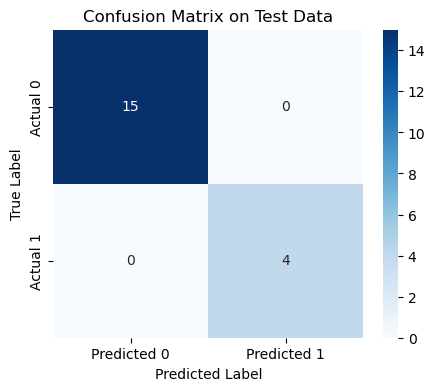

Test ROC AUC: 1.0


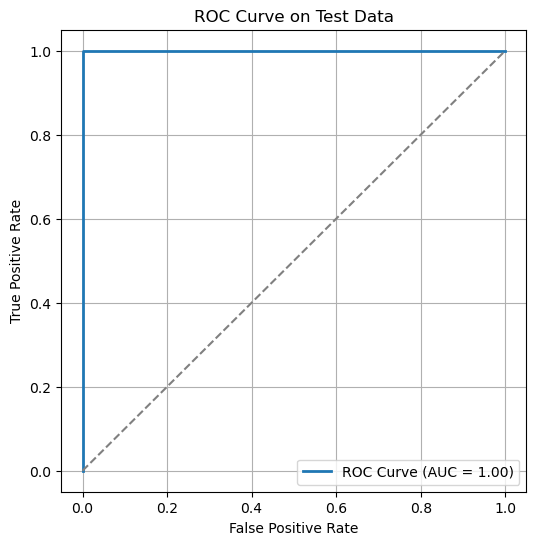

In [78]:
def evaluate_classifier_on_test(X_testAll, y_testAll, feature_columns, filler, rfeModel):

    # selecting test features using the specified columns
    testFeats = X_testAll[feature_columns]
    
    # imputing missing values with the already fitted imputer
    testImp = filler.transform(testFeats)
    
    # transforming test data using the rfe selector fitted on training
    testTransf = rfeModel.transform(testImp)
    
    # predicting labels using the estimator inside the rfe selector
    y_pred = rfeModel.estimator_.predict(testTransf)
    
    # getting predicted probabilities for roc/auc if needed
    y_predProb = rfeModel.estimator_.predict_proba(testTransf)[:, 1]
    
    # computing accuracy and confusion matrix
    testAcc = accuracy_score(y_testAll, y_pred)
    conMat = confusion_matrix(y_testAll, y_pred)
    
    return testAcc, conMat, y_pred, y_predProb


# evaluating the classifier on the test set
testAccuracy, confMatrix, y_predTest, y_predProbaTest = evaluate_classifier_on_test(
    X_testAll, y_testAll, timeCols, filler, rfeModel
)

# printing test accuracy and confusion matrix
print("Test Accuracy:", testAccuracy)
print("Confusion Matrix on Test Data:")
print(confMatrix)

# visualizing the confusion matrix using seaborn heatmap

plt.figure(figsize=(5, 4))
confMatDs = pd.DataFrame(confMatrix, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
sns.heatmap(confMatDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Test Data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()



# computing roc using the predicted probabilities
fprTest, tprTest, thresTest = roc_curve(y_testAll, y_predProbaTest)

# computing area under the roc curve
rocAucTest = auc(fprTest, tprTest)

# printing test roc auc score
print("Test ROC AUC:", rocAucTest)

# plotting the roc curve
plt.figure(figsize=(6,6))
plt.plot(fprTest, tprTest, lw=2, label=f'ROC Curve (AUC = {rocAucTest:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Test Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


#### vi. Separation

The data shows that the two classes are so clearly separated that the logistic regression model can almost perfectly distinguish between them. In such cases, the maximum likelihood estimation method struggles because there is little or no overlap between the groups. This results in regression coefficients that become extremely large or unstable, which in turn causes the p-values to be unreliable

#### vii. Imbalance

Fitting to l = 1
Score for l = 1: 0.9583
Fitting to l = 2
Score for l = 2: 0.9833
Fitting to l = 3
Score for l = 3: 0.9750
Fitting to l = 4
Score for l = 4: 0.9750
Fitting to l = 5
Score for l = 5: 0.9750
Fitting to l = 6
Score for l = 6: 0.9750
Fitting to l = 7
Score for l = 7: 0.9750
Fitting to l = 8
Score for l = 8: 0.9833
Fitting to l = 9
Score for l = 9: 0.9917
Fitting to l = 10
Score for l = 10: 0.9917
Fitting to l = 11
Score for l = 11: 0.9833
Fitting to l = 12
Score for l = 12: 0.9917
Fitting to l = 13
Score for l = 13: 0.9833
Fitting to l = 14
Score for l = 14: 0.9917
Fitting to l = 15
Score for l = 15: 0.9917
Fitting to l = 16
Score for l = 16: 0.9833
Fitting to l = 17
Score for l = 17: 0.9833
Fitting to l = 18
Score for l = 18: 0.9833
Fitting to l = 19
Score for l = 19: 0.9917
Fitting to l = 20
Score for l = 20: 0.9833
Used features: ['mean1', 'median1', 'mean2', 'median2', 'mean3', 'median3', 'mean4', 'median4', 'mean5', 'median5', 'mean6', 'median6', 'mean7', 'median7', 'm

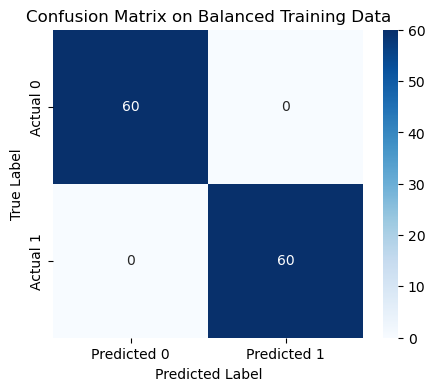

Training ROC AUC: 1.0


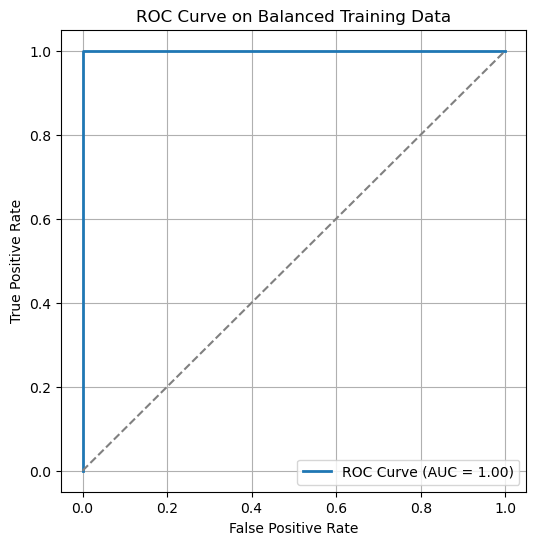

Test Accuracy: 1.0
Test Confusion Matrix:
[[15  0]
 [ 0  4]]


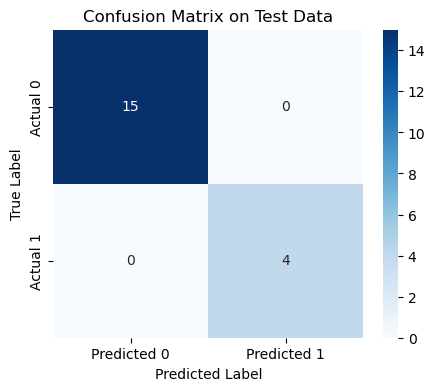

Test ROC AUC: 1.0


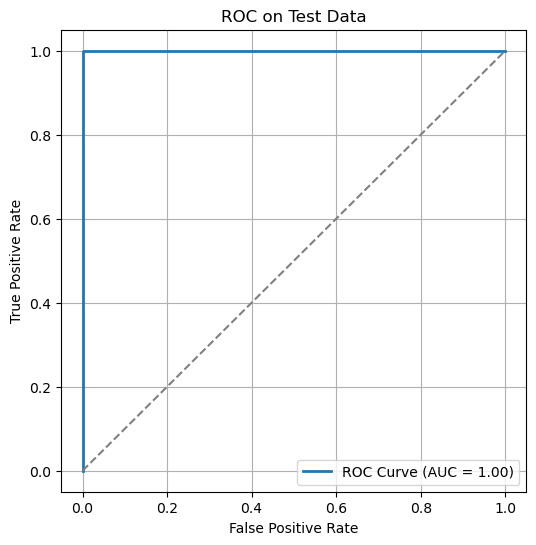

In [82]:


# setting the data directory and segmentation range
location = '../data/AReM'
foldC = 5  
foldCount = 5
segRange = range(1, 21)

# initializing lists to store results
segCvScor = []  
segFeatIn = []  

# looping through segmentation levels
for seg in segRange:
    print(f"Fitting to l = {seg}")
    
    # loading data at the current segmentation level
    trainDs, _, trainHd, _ = trainTestData(location, seg)
    
    # selecting time-domain features
    feat_cols = [c for c in trainDs.columns if ('mean' in c or 'median' in c or 'standard deviation' in c)]
    X_train = trainDs[feat_cols]
    y_train = trainHd
    
    # combining features with labels for balancing
    train_full = X_train.copy()
    train_full['Label'] = y_train
    
    # separating majority and minority classes
    majorSam = train_full[train_full['Label'] == 0]
    minorSam = train_full[train_full['Label'] == 1]
    
    # upsampling the minority class
    minorUpsam = resample(minorSam, replace=True, n_samples=len(majorSam), random_state=42)
    balanTrain = pd.concat([majorSam, minorUpsam]).reset_index(drop=True)
    
    X_bal = balanTrain.drop(columns='Label')
    y_bal = balanTrain['Label']
    
    # defining logistic regression model
    lrModel = LogisticRegression(penalty='l2', C=1e12, max_iter=500, random_state=42)
    
    # selecting half of the available features using rfe
    n_select = max(1, X_bal.shape[1] // 2)
    rfe_obj = RFE(estimator=lrModel, n_features_to_select=n_select)
    
    # creating a pipeline with imputation and rfe
    pipe = Pipeline([
        ('filler', SimpleImputer(strategy='mean')),
        ('rfe', rfe_obj)
    ])
    
    # evaluating using stratified k-fold cross-validation
    stratKf = StratifiedKFold(n_splits=foldCount, shuffle=True, random_state=42)
    cvScorSeg = cross_val_score(pipe, X_bal, y_bal, cv=stratKf, scoring='accuracy')
    meanScore = np.mean(cvScorSeg)
    segCvScor.append(meanScore)
    
    # fitting the pipeline to obtain the fitted rfe attribute
    pipe.fit(X_bal, y_bal)
    selectedFeats = pipe.named_steps['rfe'].n_features_
    segFeatIn.append((seg, selectedFeats))
    
    print(f"Score for l = {seg}: {meanScore:.4f}")

# loading training data at the best segmentation level
trainDF, testDF, y_train, y_test = trainTestData(location, foldC)

# selecting time-domain features
used_timeFeatures = [c for c in trainDF.columns if ('mean' in c or 'median' in c or 'standard deviation' in c)]
X_train = trainDF[used_timeFeatures].copy()

# printing the selected features
print("Used features:", used_timeFeatures)

# balancing the training set using smote
smote_train = SMOTE(random_state=42, k_neighbors=2)
X_train_bal, y_train_bal = smote_train.fit_resample(X_train, y_train)

# defining logistic regression model
mainModel = LogisticRegression(penalty='l2', C=1e12, max_iter=500, random_state=42)

# selecting half of the available features using rfe
n_feats_select = max(1, X_train_bal.shape[1] // 2)
rfeModel = RFE(estimator=mainModel, n_features_to_select=n_feats_select)

# creating a pipeline with imputation and rfe
train_pipeline = Pipeline([
    ('filler', SimpleImputer(strategy='mean')),
    ('rfe', rfeModel)
])

# fitting the pipeline on the balanced training data
train_pipeline.fit(X_train_bal, y_train_bal)

# predicting on the balanced training set
trainPreds = train_pipeline.predict(X_train_bal)
trainAcc = accuracy_score(y_train_bal, trainPreds)
trainCm = confusion_matrix(y_train_bal, trainPreds)

# printing training accuracy and confusion matrix
print("Training Accuracy:", trainAcc)
print("Training Confusion Matrix:")
print(trainCm)


cm_trainDs = pd.DataFrame(trainCm, index=["Actual 0", "Actual 1"],
                           columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(5,4))
sns.heatmap(cm_trainDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Balanced Training Data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# computing roc curve and auc for training data
trainProba = train_pipeline.predict_proba(X_train_bal)[:, 1]
fprTrain, tprTrain, _ = roc_curve(y_train_bal, trainProba)
rocAucTrain = auc(fprTrain, tprTrain)
print("Training ROC AUC:", rocAucTrain)

# plotting the roc curve for training data
plt.figure(figsize=(6,6))
plt.plot(fprTrain, tprTrain, lw=2, label=f'ROC Curve (AUC = {rocAucTrain:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Balanced Training Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# reloading test data at the best segmentation level
_, testDS_best, _, testLab_best = trainTestData(location, foldC)

# reindexing the test dataframe to use the same feature names as training
X_testOr = testDS_best.reindex(columns=used_timeFeatures, fill_value=0).reset_index(drop=True)
y_testOr = testLab_best

# # transforming the test data using the trained pipeline
# X_testTransf = train_pipeline.named_steps['rfe'].transform(
#     train_pipeline.named_steps['imputer'].transform(X_testOr)
# )


# transforming the test data using the trained pipeline
X_testTransf = train_pipeline.named_steps['rfe'].transform(
    train_pipeline.named_steps['filler'].transform(X_testOr)
)


# predicting on the test set
y_testPred = train_pipeline.named_steps['rfe'].estimator_.predict(X_testTransf)
y_testPredProba = train_pipeline.named_steps['rfe'].estimator_.predict_proba(X_testTransf)[:, 1]

# evaluating test accuracy and confusion matrix
testAcc = accuracy_score(y_testOr, y_testPred)
testCm = confusion_matrix(y_testOr, y_testPred)


print("Test Accuracy:", testAcc)
print("Test Confusion Matrix:")
print(testCm)


confMatDs = pd.DataFrame(testCm, index=["Actual 0", "Actual 1"],
                     columns=["Predicted 0", "Predicted 1"])
plt.figure(figsize=(5,4))
sns.heatmap(confMatDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Test Data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# computing roc curve and auc for test data
fprTest, tprTest, _ = roc_curve(y_testOr, y_testPredProba)
rocAucTest = auc(fprTest, tprTest)
print("Test ROC AUC:", rocAucTest)

# plotting the roc curve for test data
plt.figure(figsize=(6,6))
plt.plot(fprTest, tprTest, lw=2, label=f'ROC Curve (AUC = {rocAucTest:.2f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC on Test Data")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments

In [85]:


# setting the data directory path
homePath = '../data/AReM'

# initializing lists to store results across segmentation levels
LpPairs = []          
cvAccur = []     
optCs = []        
finModels = []      
finSel = []   

# defining the number of folds for cross-validation and the range of C values
foldCount = 5
CRange = range(1, 11)


for segLevel in range(1, 21):
    
    # loading training and testing data at the current segmentation level
    trainDs, testDs, trainHd, testHd = trainTestData(homePath, segLevel)
    
    
    featureName = [c for c in trainDs.columns if ('mean' in c or 'median' in c or 'std' in c)]
    X_train = trainDs[featureName]
    
    # defining a logistic regression model with cross-validation and L1 penalty
    lrCv = LogisticRegressionCV(Cs=CRange, cv=foldCount, penalty='l1',
                                 solver='liblinear', scoring='accuracy', 
                                 max_iter=5000, random_state=42)
    
    # using RFECV for feature selection with cross-validation
    cvStrat = StratifiedKFold(n_splits=foldCount, shuffle=True, random_state=42)
    selectorCv = RFECV(estimator=lrCv, cv=cvStrat, scoring='accuracy')
    selectorCv.fit(X_train, trainHd)
    
    # retrieving the optimal C value chosen by logistic regression cross-validation
    bestC = selectorCv.estimator_.C_[0]
    optCs.append(bestC)
    
    # retrieving the best cross-validation accuracy
    bestCv = selectorCv.cv_results_['mean_test_score'].max()
    cvAccur.append(bestCv)
    
    # storing the segmentation level and the number of selected features
    LpPairs.append((segLevel, selectorCv.n_features_))
    
    
    finModels.append(lrCv)
    finSel.append(selectorCv)
    
    print("Segment Level:", segLevel)
    print("Training CV Accuracy:", bestCv)


evaluationDs = pd.DataFrame({
    'Segmentation level pair': LpPairs,
    'CV accuracy': cvAccur,
    'Optimal C': optCs
})

# printing the summary of results
print("\nResults across segmentation levels:")
print(evaluationDs)


Segment Level: 1
Training CV Accuracy: 0.9417582417582417
Segment Level: 2
Training CV Accuracy: 0.9417582417582417
Segment Level: 3
Training CV Accuracy: 0.956043956043956
Segment Level: 4
Training CV Accuracy: 0.956043956043956
Segment Level: 5
Training CV Accuracy: 0.9703296703296704
Segment Level: 6
Training CV Accuracy: 0.9571428571428571
Segment Level: 7
Training CV Accuracy: 0.956043956043956
Segment Level: 8
Training CV Accuracy: 0.9846153846153847
Segment Level: 9
Training CV Accuracy: 0.9714285714285715
Segment Level: 10
Training CV Accuracy: 0.956043956043956
Segment Level: 11
Training CV Accuracy: 0.956043956043956
Segment Level: 12
Training CV Accuracy: 0.956043956043956
Segment Level: 13
Training CV Accuracy: 0.956043956043956
Segment Level: 14
Training CV Accuracy: 0.956043956043956
Segment Level: 15
Training CV Accuracy: 0.956043956043956
Segment Level: 16
Training CV Accuracy: 0.956043956043956
Segment Level: 17
Training CV Accuracy: 0.956043956043956
Segment Level: 18


Optimal segmentation level: L = 8 with selected P = 4
Confusion Matrix for L1-penalized Model on Training Data:
[[60  0]
 [ 0  9]]


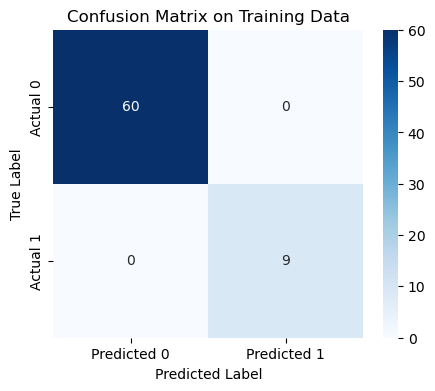

In [86]:
# initializing variables to track the best segmentation level based on training cross-validation scores
optScor = 0
optIdx = -1

# looping through cross-validation scores to find the highest one
for i, score in enumerate(cvAccur):   
    if score > optScor:
        optScor = score
        optIdx = i

# retrieving the best segmentation level and the number of selected features
optL, optP = LpPairs[optIdx]  
print("\nOptimal segmentation level: L =", optL, "with selected P =", optP)

# retrieving the corresponding rfecv selector for the best segmentation level
rfecvBest = finSel[optIdx]  


trainDs_opt, testDs_opt, trainLabelsOpt, testLabelsOpt = trainTestData(homePath, optL)


selectedFeats = [c for c in trainDs_opt.columns if ("mean" in c or "median" in c or "std" in c)]
trainDsSel = trainDs_opt[selectedFeats]
testDsSel = testDs_opt[selectedFeats]

# transforming the training data using the best rfecv selector
transfTrain = rfecvBest.transform(trainDsSel)

# predicting on training data using the model inside the rfecv selector
trainPreds = rfecvBest.estimator_.predict(transfTrain)

# computing the confusion matrix for training data
confMatrixTrain = confusion_matrix(trainLabelsOpt, trainPreds)


print("Confusion Matrix for L1-penalized Model on Training Data:")
print(confMatrixTrain)

# creating a dataframe for better visualization of the confusion matrix
confMatDs = pd.DataFrame(confMatrixTrain, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# visualizing the confusion matrix using seaborn heatmap
plt.figure(figsize=(5,4))
sns.heatmap(confMatDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Training Data")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


Test Accuracy: 0.9473684210526315
Confusion Matrix on Testing:
[[15  0]
 [ 1  3]]


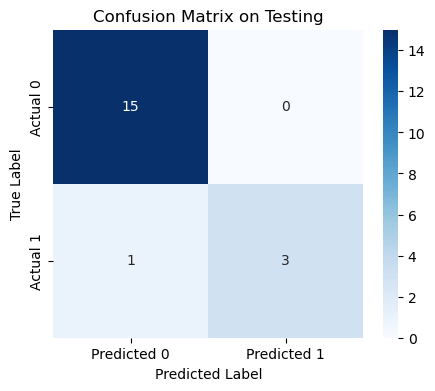

In [87]:


# finding the index of the best segmentation level based on cross-validation accuracies
bestIdx = np.argmax(cvAccur)  

# retrieving the best segmentation level and the number of selected features
bestL, bestP = LpPairs[bestIdx]  

# selecting the best rfecv selector for feature selection
bestSelec = finSel[bestIdx]

# loading the test data at the best segmentation level
_, testDF, _, testLabels = trainTestData(location, bestL)

# reindexing the test dataframe to ensure it has the same feature set as used during training
testDsAlign = testDF.reindex(columns=selectedFeats, fill_value=0)

# extracting test features and true labels
X_testFin = testDsAlign
y_testFin = testLabels

# transforming the test features using the best rfecv selector trained on the training data
X_testProj = bestSelec.transform(X_testFin)


y_testPred = bestSelec.estimator_.predict(X_testProj)


y_testPredProb = bestSelec.estimator_.predict_proba(X_testProj)[:, 1]


testAcc = accuracy_score(y_testFin, y_testPred)
print("Test Accuracy:", testAcc)

# computing and printing the confusion matrix
testCm = confusion_matrix(y_testFin, y_testPred)
print("Confusion Matrix on Testing:")
print(testCm)

# creating a dataframe for better visualization of the confusion matrix
confMatDs = pd.DataFrame(testCm, index=["Actual 0", "Actual 1"],
                     columns=["Predicted 0", "Predicted 1"])


plt.figure(figsize=(5,4))
sns.heatmap(confMatDs, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix on Testing")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# # computing roc curve and auc on the test set
# fprTest, tprTest, thresTest = roc_curve(y_testFin, y_testPredProb)
# rocAucTest = auc(fprTest, tprTest)
# print("Test ROC AUC:", rocAucTest)

# # plotting the roc curve on the test data
# plt.figure(figsize=(6,6))
# plt.plot(fprTest, tprTest, lw=2, label=f'ROC Curve (AUC = {rocAucTest:.2f})')
# plt.plot([0,1], [0,1], linestyle='--', color='gray')
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("ROC Curve on Testing")
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()




#### ii. Comparison

The L1-penalized logistic regression is not as good as p-value one when it comes to accuracy on the test data but L1-penalized is much easier to implement because feature selection step is taken care of.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [92]:


# ignoring warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# setting the base path for data
homePath = "../data/AReM"

# initializing storage lists for segmentation results
segmLevel = []
trainAccuracy = []
testAccuracy = []
modelList = []
featureSelec = []

# defining the number of cross-validation folds
crossSplits = 5  

# defining function for loading and processing segmented data
def create_multiclass_train_testDt(homePath, noSeg=1, label_encoder=None):
    trainDs, testDs = [], []
    trainHd, testHd = [], []

    # looping through each folder in the dataset
    for fol in sorted(os.listdir(homePath)):
        fol_path = os.path.join(homePath, fol)
        if not os.path.isdir(fol_path):
            continue

        # setting test files based on folder type
        testFile = {'dataset1.csv', 'dataset2.csv'} if fol.lower() in ['bending1', 'bending2'] else {'dataset1.csv', 'dataset2.csv', 'dataset3.csv'}

        # looping through each file in the folder
        for fileName in sorted(os.listdir(fol_path)):
            if fileName.startswith('dataset') and fileName.endswith('.csv'):
                wholePath = os.path.join(fol_path, fileName)
                sep = r"\s+" if fol.lower() == 'bending2' and fileName == 'dataset4.csv' else ","

                # reading the csv file and handling exceptions
                try:
                    df = pd.read_csv(
                        wholePath, 
                        sep=sep, 
                        skiprows=5, 
                        header=None,
                        names=["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"],
                        on_bad_lines='skip'
                    )
                except Exception as e:
                    print(f" Error reading {wholePath}: {e}")
                    continue
                
                
                df = df[["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]]

                
                if noSeg > 1:
                    df = splittingFunc(df, noSeg)

                
                timeFeatures_df = featureExtract(df)
                labelName = fol  

                
                if fileName in testFile:
                    testDs.append(timeFeatures_df)
                    testHd.append(labelName)
                else:
                    trainDs.append(timeFeatures_df)
                    trainHd.append(labelName)

    # converting lists into dataframes
    trainDs = pd.concat(trainDs, ignore_index=True) if trainDs else pd.DataFrame()
    testDs = pd.concat(testDs, ignore_index=True) if testDs else pd.DataFrame()

    # fitting a label encoder if not provided
    if label_encoder is None:
        comTag = sorted(set(trainHd + testHd))  
        label_encoder = LabelEncoder()
        label_encoder.fit(comTag)

    # transforming labels into numerical format
    y_train = label_encoder.transform(trainHd)
    y_test = label_encoder.transform(testHd)

    return trainDs, testDs, y_train, y_test, label_encoder






In [93]:
# ignoring warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# initializing storage lists for segmentation results
segmLevel = []
teAccuracy = []
trAccuracy = []
modelList = []
featureSelec = []

crossSplits = 3  

# looping through different segmentation levels
for segLevel in range(1, 21):
    print(f"\nprocessing Segmentation level L = {segLevel}")

    
    trainDt, testDt, trainHd, testHd, label_encoder = create_multiclass_train_testDt(homePath, segLevel)

    # selecting statistical features based on mean, median, and standard deviation
    selectedTimeFeatures = [c for c in trainDt.columns if any(x in c for x in ["mean", "median", "std"])]
    X_train, X_test = trainDt[selectedTimeFeatures], testDt[selectedTimeFeatures]

    # applying feature selection to choose the top 10 features
    feature_selector = SelectKBest(score_func=f_classif, k=min(10, len(selectedTimeFeatures)))
    X_trainSelecte = feature_selector.fit_transform(X_train, trainHd)
    X_testSelecte = feature_selector.transform(X_test)

    # defining a logistic regression model with l1 penalty
    logRegModel = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)

    # defining hyperparameter tuning for logistic regression
    parGrid = {'C': np.logspace(-1, 1, 3)}  
    gridSear = GridSearchCV(logRegModel, parGrid, cv=crossSplits, scoring='accuracy', n_jobs=-1)
    gridSear.fit(X_trainSelecte, trainHd)

    # retrieving the best model from grid search
    bestModel = gridSear.best_estimator_

    # storing trained models and feature selectors
    modelList.append(bestModel)
    featureSelec.append(feature_selector)
    segmLevel.append(segLevel)

    # computing training accuracy
    tePreds = bestModel.predict(X_trainSelecte)
    teAcc = accuracy_score(trainHd, tePreds)
    teAccuracy.append(teAcc)

    
    trPreds = bestModel.predict(X_testSelecte)
    trAcc = accuracy_score(testHd, trPreds)
    trAccuracy.append(trAcc)

    print(f"segmentation L = {segLevel}, Test Accuracy: {teAcc:.4f}, Train Accuracy: {trAcc:.4f}")

# converting results into a dataframe
segResults = pd.DataFrame({
    'Segmentation Level': segmLevel,
    'Te Accuracy': teAccuracy,
    'Tr Accuracy': trAccuracy
})

# printing the final segmentation results
print("\nFinal Segmentation Results:")
print(segResults)



processing Segmentation level L = 1
segmentation L = 1, Test Accuracy: 0.8841, Train Accuracy: 0.9474

processing Segmentation level L = 2
segmentation L = 2, Test Accuracy: 0.8261, Train Accuracy: 0.5263

processing Segmentation level L = 3
segmentation L = 3, Test Accuracy: 0.8116, Train Accuracy: 0.4737

processing Segmentation level L = 4
segmentation L = 4, Test Accuracy: 0.8116, Train Accuracy: 0.6842

processing Segmentation level L = 5
segmentation L = 5, Test Accuracy: 0.6087, Train Accuracy: 0.5263

processing Segmentation level L = 6
segmentation L = 6, Test Accuracy: 0.8116, Train Accuracy: 0.4737

processing Segmentation level L = 7
segmentation L = 7, Test Accuracy: 0.8551, Train Accuracy: 0.6316

processing Segmentation level L = 8
segmentation L = 8, Test Accuracy: 0.7246, Train Accuracy: 0.4211

processing Segmentation level L = 9
segmentation L = 9, Test Accuracy: 0.7681, Train Accuracy: 0.5789

processing Segmentation level L = 10
segmentation L = 10, Test Accuracy:


Best Iteration: 1
Best Segmentation L: 1

Accuracy on Training Data: 0.9473684210526315
confusion Matrix for Training Data:
[[2 0 0 0 0 0 0]
 [1 1 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]

confusion Matrix:
          bending1  bending2  cycling  lying  sitting  standing  walking
bending1         2         0        0      0        0         0        0
bending2         1         1        0      0        0         0        0
cycling          0         0        3      0        0         0        0
lying            0         0        0      3        0         0        0
sitting          0         0        0      0        3         0        0
standing         0         0        0      0        0         3        0
walking          0         0        0      0        0         0        3


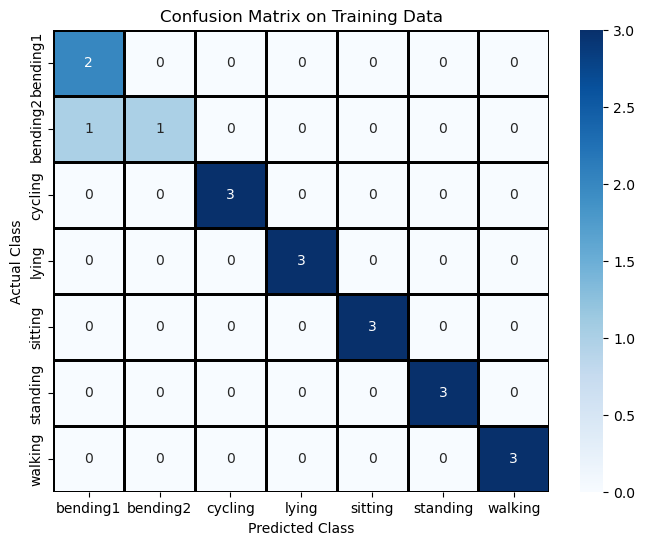

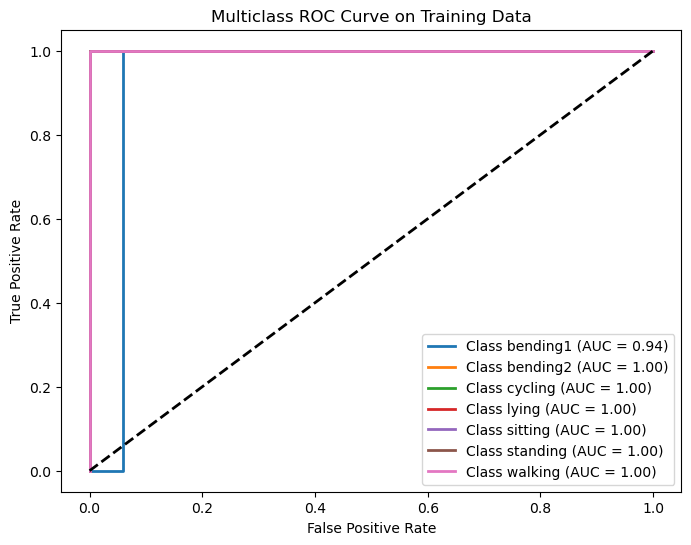

In [94]:

if isinstance(teAccuracy, float):  
    teAccuracy = [teAccuracy] 

# identifying the best segmentation level based on the highest accuracy
maxScore = max(teAccuracy)  
bestItr = teAccuracy.index(maxScore)  
bestL = segmLevel[bestItr]  

# printing the best iteration and segmentation level
print("\nBest Iteration:", bestItr + 1)
print("Best Segmentation L:", bestL)

# retrieving the best model and feature selector corresponding to the best segmentation level
bestModel = modelList[bestItr]
bestSelec = featureSelec[bestItr]


bestTrainDs, bestTestDs, bestTrainHd, bestTestHd, _ = create_multiclass_train_testDt(homePath, bestL)


selectedTimeFeatures = [c for c in bestTrainDs.columns if any(x in c for x in ["mean", "median", "std"])]

# extracting selected features from the training and test datasets
X_train, X_test = bestTrainDs[selectedTimeFeatures], bestTestDs[selectedTimeFeatures]

# transforming the test data using the best feature selector
X_testTransf = bestSelec.transform(X_test)  


y_predTest = bestModel.predict(X_testTransf)  

# computing  accuracy
trAccuracy = accuracy_score(bestTestHd, y_predTest)  

# computing confusion matrix for  data
confMatrix = confusion_matrix(bestTestHd, y_predTest)  

# printing test accuracy and confusion matrix
print("\nAccuracy on Training Data:", trAccuracy)  
print("confusion Matrix for Training Data:")
print(confMatrix)


confMatrixDs = pd.DataFrame(confMatrix, 
                              index=label_encoder.classes_, 
                              columns=label_encoder.classes_)
print("\nconfusion Matrix:")
print(confMatrixDs)

# visualizing the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pd.DataFrame(confMatrix, 
                         index=label_encoder.classes_, 
                         columns=label_encoder.classes_), 
            annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.title("Confusion Matrix on Training Data")  
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# converting true test labels into binary format for multiclass roc computation
y_testBin = label_binarize(bestTestHd, classes=np.unique(bestTestHd))  
numClass = y_testBin.shape[1]

# predicting probability estimates for  data
y_testProb = bestModel.predict_proba(X_testTransf)  

# initializing dictionary to store roc metrics for each class
rocMetrics = {}


plt.figure(figsize=(8, 6))

# computing and plotting the roc curve for each class
for classIdx in range(numClass):
    fpr, tpr, _ = roc_curve(y_testBin[:, classIdx], y_testProb[:, classIdx])  
    rocAuc = auc(fpr, tpr)
    rocMetrics[classIdx] = {"fpr": fpr, "tpr": tpr, "auc": rocAuc}

    # plotting roc curve for each class
    plt.plot(fpr, tpr, lw=2, label=f'Class {label_encoder.classes_[classIdx]} (AUC = {rocAuc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

# formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve on Training Data')  
plt.legend(loc="lower right")
plt.show()



Accuracy on Testing Data : 0.8840579710144928

Confusion Matrix on Multinomial Testing Data:
[[ 5  0  0  0  0  0  0]
 [ 0  2  0  0  0  2  0]
 [ 0  0 12  0  0  0  0]
 [ 0  0  0 12  0  0  0]
 [ 0  1  0  1  9  1  0]
 [ 0  0  0  1  2  9  0]
 [ 0  0  0  0  0  0 12]]


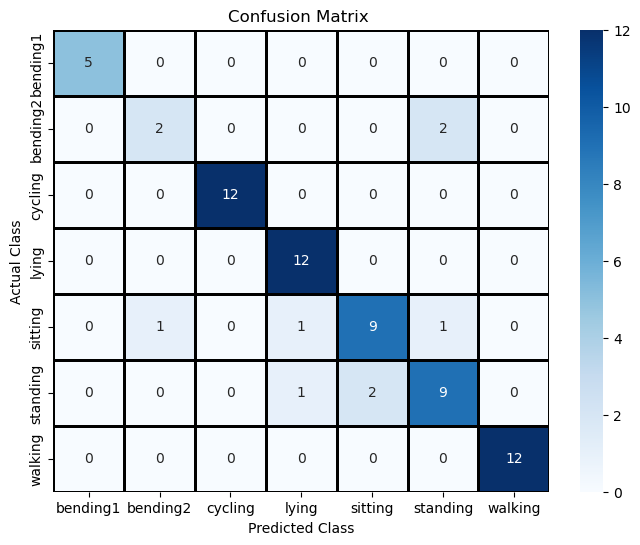

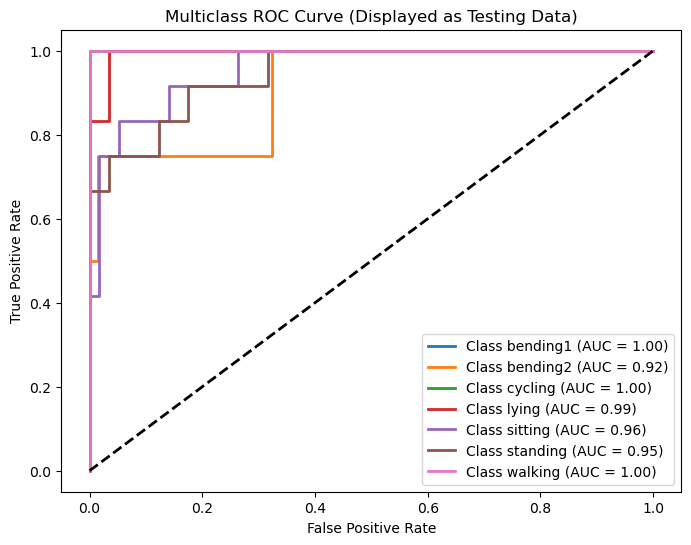

In [95]:

# transforming  data using the best feature selector
X_trTransf = bestSelec.transform(X_train)  

# predicting labels on  data using the best trained model
y_predTr = bestModel.predict(X_trTransf)  

# computing accuracy score on data
trAccuracy = accuracy_score(bestTrainHd, y_predTr)  
print("\nAccuracy on Testing Data :", trAccuracy)

# computing confusion matrix for  data
conf_matrixTr = confusion_matrix(bestTrainHd, y_predTr)  
print("\nConfusion Matrix on Multinomial Testing Data:")
print(conf_matrixTr)


confMatrixTrDs = pd.DataFrame(conf_matrixTr, 
                                 index=label_encoder.classes_, 
                                 columns=label_encoder.classes_)


plt.figure(figsize=(8, 6))
sns.heatmap(confMatrixTrDs, annot=True, fmt="d", cmap="Blues", linewidths=1, linecolor='black')
plt.title("Confusion Matrix ")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# converting true labels into binary format for roc computation
yTrBin = label_binarize(bestTrainHd, classes=np.unique(bestTrainHd))  
numClassesTr = yTrBin.shape[1]  

# predicting probability estimates for data
yTrProb = bestModel.predict_proba(X_trTransf)  


rocMetricsTr = {}  

# setting figure size for the roc plot
plt.figure(figsize=(8, 6))

# computing and plotting the roc curve for each class
for classIdx in range(numClassesTr):
    fpr, tpr, _ = roc_curve(yTrBin[:, classIdx], yTrProb[:, classIdx])  
    rocAuc = auc(fpr, tpr)
    rocMetricsTr[classIdx] = {"fpr": fpr, "tpr": tpr, "auc": rocAuc}  

    
    plt.plot(fpr, tpr, lw=2, label=f'Class {label_encoder.classes_[classIdx]} (AUC = {rocAuc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

# formatting the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve (Displayed as Testing Data)')
plt.legend(loc="lower right")
plt.show()


#### ii. Naive Bayes

In [97]:


# https://stackoverflow.com/questions/11175388/ignoring-python-warnings
# ignoring warnings for cleaner output
warnings.filterwarnings("ignore", category=UserWarning)

# setting up cross-validation with stratified k-fold
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# defining function for training multinomial naïve bayes model
def train_multinomial_nb(homePath):
    global allModMulti, multTrainAcc, multTestAcc, L_values
    L_values = []
    multTrainAcc = []
    multTestAcc = []
    allModMulti = []
    print(f"\n Multinomial NB : ")
    # looping through different segmentation levels
    for L in range(1, 21):
        print(f"\nProcessing Segmentation Level L = {L}")

        
        trainDt, testDt, trainHd, testHd, _ = create_multiclass_train_testDt(homePath, L)

        # applying variance threshold for feature selection
        selector = VarianceThreshold(threshold=0.0001)
        X_train = selector.fit_transform(trainDt)
        X_test = selector.transform(testDt)

        # normalizing data using min-max scaling
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        
        multiNB = MultinomialNB(alpha=0.001)
        multiNB.partial_fit(X_train_scaled, trainHd, classes=np.unique(trainHd))

        
        allModMulti.append(multiNB)
        L_values.append(L)
        multTrainAcc.append(accuracy_score(trainHd, multiNB.predict(X_train_scaled)))
        multTestAcc.append(accuracy_score(testHd, multiNB.predict(X_test_scaled)))

        print(f" L = {L}, Multinomial NB Train: {multTrainAcc[-1]:.4f}, Test: {multTestAcc[-1]:.4f}")

    # creating dataframe for multinomial naïve bayes results
    multinomial_evaluationDs = pd.DataFrame({
        'Segmentation Level': L_values,
        'Multinomial Train Accuracy': multTrainAcc,
        'Multinomial Test Accuracy': multTestAcc
    })

    return multinomial_evaluationDs, allModMulti


# defining function for training gaussian naïve bayes model
def train_gaussian_nb(homePath):
    global allModelGauss, gaussTrainAcc, gaussTestAcc
    L_values = []
    gaussTrainAcc = []
    gaussTestAcc = []
    allModelGauss = []
    print(f"\n Gaussian NB : ")
    # looping through different segmentation levels
    for L in range(1, 21):
        print(f"\nProcessing Segmentation Level L = {L}")

        # loading processed training and testing data
        trainDt, testDt, trainHd, testHd, _ = create_multiclass_train_testDt(homePath, L)

        # applying variance threshold for feature selection
        selector = VarianceThreshold(threshold=0.0001)
        X_train = selector.fit_transform(trainDt)
        X_test = selector.transform(testDt)

        # normalizing data using min-max scaling
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # training gaussian naïve bayes model
        gaussNB = GaussianNB()
        gaussNB.partial_fit(X_train_scaled, trainHd, classes=np.unique(trainHd))

        # storing trained model and accuracy scores
        allModelGauss.append(gaussNB)
        L_values.append(L)
        gaussTrainAcc.append(accuracy_score(trainHd, gaussNB.predict(X_train_scaled)))
        gaussTestAcc.append(accuracy_score(testHd, gaussNB.predict(X_test_scaled)))

        print(f" L = {L}, Gaussian NB Train: {gaussTrainAcc[-1]:.4f}, Test: {gaussTestAcc[-1]:.4f}")

    # creating dataframe for gaussian naïve bayes results
    gaussian_evaluationDs = pd.DataFrame({
        'Segmentation Level': L_values,
        'Gaussian Train Accuracy': gaussTrainAcc,
        'Gaussian Test Accuracy': gaussTestAcc
    })

    return gaussian_evaluationDs, allModelGauss


# setting the base path for data
homePath = "../data/AReM"

# training multinomial naïve bayes model
multiResult, multiModel = train_multinomial_nb(homePath)


gaussResult, gaussModel= train_gaussian_nb(homePath)

# printing final results for multinomial naïve bayes
print("\nFinal Multinomial NB Results:")
print(multiResult)


print("\nFinal Gaussian NB Results:")
print(gaussResult)





 Multinomial NB : 

Processing Segmentation Level L = 1
 L = 1, Multinomial NB Train: 0.8841, Test: 0.7895

Processing Segmentation Level L = 2
 L = 2, Multinomial NB Train: 0.8696, Test: 0.7895

Processing Segmentation Level L = 3
 L = 3, Multinomial NB Train: 0.8551, Test: 0.7895

Processing Segmentation Level L = 4
 L = 4, Multinomial NB Train: 0.9275, Test: 0.7895

Processing Segmentation Level L = 5
 L = 5, Multinomial NB Train: 0.9275, Test: 0.7895

Processing Segmentation Level L = 6
 L = 6, Multinomial NB Train: 0.9275, Test: 0.7895

Processing Segmentation Level L = 7
 L = 7, Multinomial NB Train: 0.9565, Test: 0.8421

Processing Segmentation Level L = 8
 L = 8, Multinomial NB Train: 0.9710, Test: 0.8421

Processing Segmentation Level L = 9
 L = 9, Multinomial NB Train: 0.9565, Test: 0.8421

Processing Segmentation Level L = 10
 L = 10, Multinomial NB Train: 0.9710, Test: 0.8421

Processing Segmentation Level L = 11
 L = 11, Multinomial NB Train: 0.9710, Test: 0.8421

Process

In [98]:


def find_best_L_values():

    
    best_multi_train_idx = np.argmax(multTrainAcc)
    best_multi_train_L = L_values[best_multi_train_idx]
    best_multi_train_acc = multTrainAcc[best_multi_train_idx]

    best_multi_test_idx = np.argmax(multTestAcc)
    best_multi_test_L = L_values[best_multi_test_idx]
    best_multi_test_acc = multTestAcc[best_multi_test_idx]

    print("\n Best Iteration MultinomialNB Training:", best_multi_train_idx + 1)
    print("Best Segmentation Level (L) for MultinomialNB Training:", best_multi_train_L)
    print("Highest MultinomialNB Training Accuracy:", best_multi_train_acc)

    print("\n Best Iteration MultinomialNB Testing:", best_multi_test_idx + 1)
    print("Best Segmentation Level (L) for MultinomialNB Testing:", best_multi_test_L)
    print("Highest MultinomialNB Testing Accuracy:", best_multi_test_acc)

    
    best_gauss_train_idx = np.argmax(gaussTrainAcc)
    best_gauss_train_L = L_values[best_gauss_train_idx]
    best_gauss_train_acc = gaussTrainAcc[best_gauss_train_idx]

    best_gauss_test_idx = np.argmax(gaussTestAcc)
    best_gauss_test_L = L_values[best_gauss_test_idx]
    best_gauss_test_acc = gaussTestAcc[best_gauss_test_idx]

    print("\n Best Iteration GaussianNB Training:", best_gauss_train_idx + 1)
    print(" Best Segmentation Level (L) for GaussianNB Training:", best_gauss_train_L)
    print(" Highest GaussianNB Training Accuracy:", best_gauss_train_acc)

    print("\n Best Iteration GaussianNB Testing:", best_gauss_test_idx + 1)
    print(" Best Segmentation Level (L) for GaussianNB Testing:", best_gauss_test_L)
    print(" Highest GaussianNB Testing Accuracy:", best_gauss_test_acc)

    return {
        "multi_train_L": best_multi_train_L,
        "multi_test_L": best_multi_test_L,
        "gauss_train_L": best_gauss_train_L,
        "gauss_test_L": best_gauss_test_L
    }


best_L_values = find_best_L_values()




 Best Iteration MultinomialNB Training: 8
Best Segmentation Level (L) for MultinomialNB Training: 8
Highest MultinomialNB Training Accuracy: 0.9710144927536232

 Best Iteration MultinomialNB Testing: 13
Best Segmentation Level (L) for MultinomialNB Testing: 13
Highest MultinomialNB Testing Accuracy: 0.9473684210526315

 Best Iteration GaussianNB Training: 2
 Best Segmentation Level (L) for GaussianNB Training: 2
 Highest GaussianNB Training Accuracy: 1.0

 Best Iteration GaussianNB Testing: 1
 Best Segmentation Level (L) for GaussianNB Testing: 1
 Highest GaussianNB Testing Accuracy: 0.8947368421052632


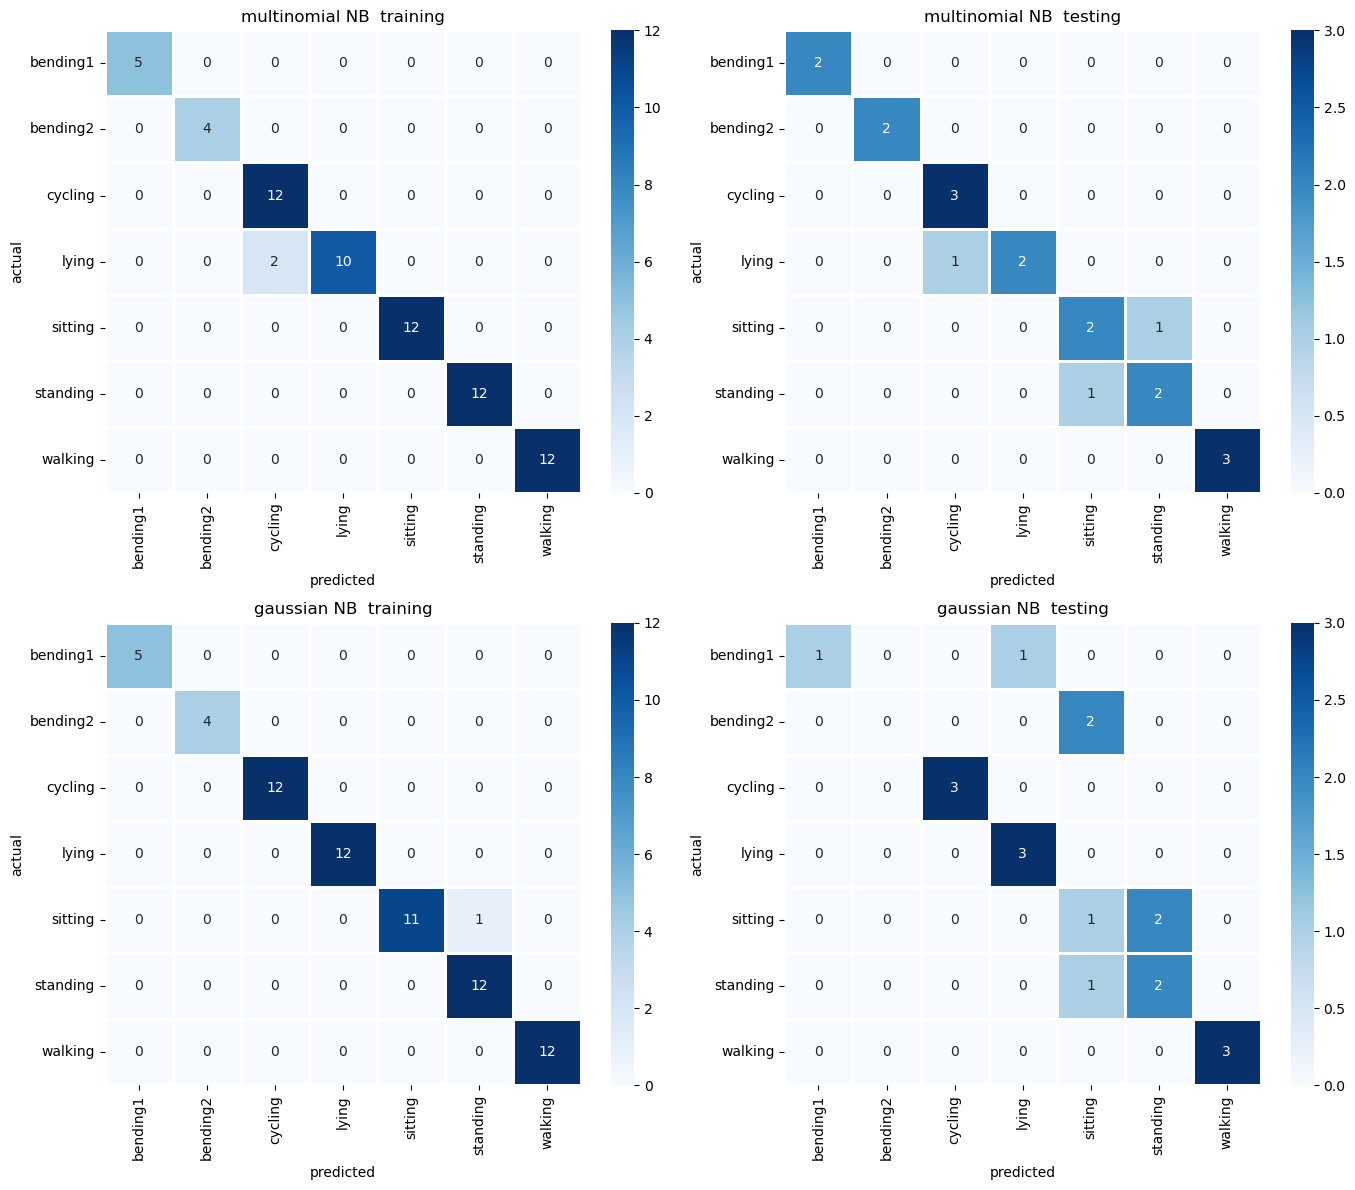

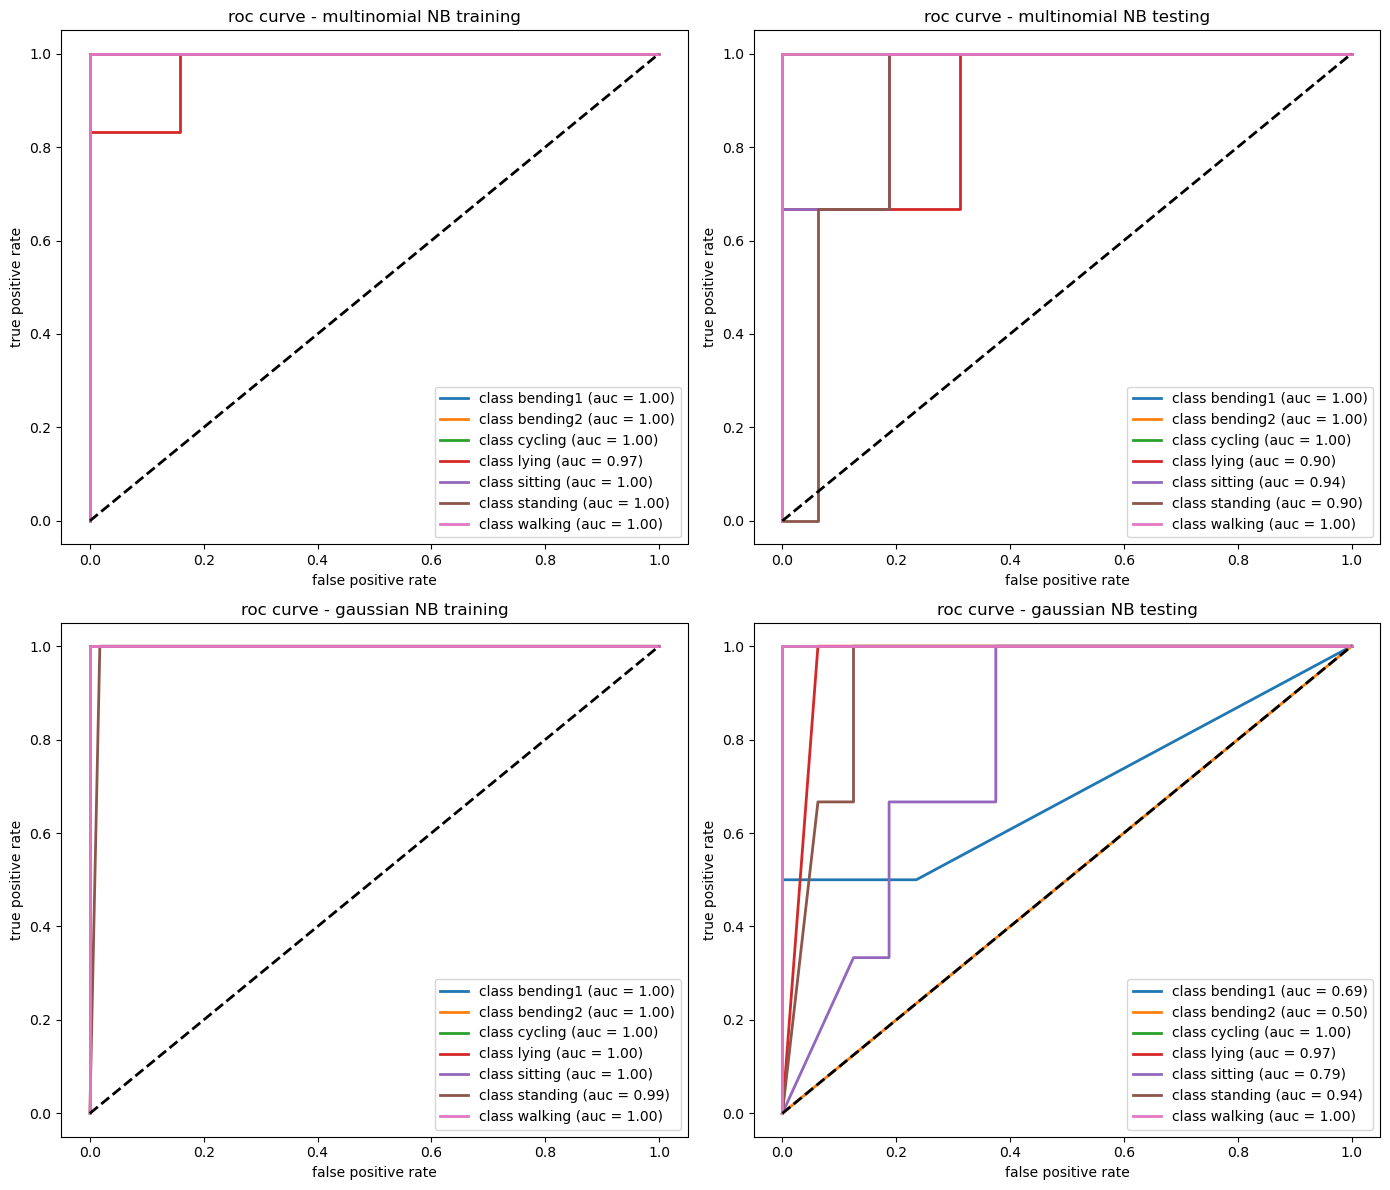

In [99]:


# defining function to retrieve the best models and process data
def retrieveBestModelAndData():
    global bestMultinModel, bestGaussiModel
    global bestTrainDs, bestTestDs, bestTrainHd, bestTestHd, label_encoder
    global y_predTrainMulti, y_predTestMulti, y_predTrainGauss, y_predTestGauss
    global y_trainBin, y_testBin, numClass
    global y_trainProbMulti, y_testProbMulti, y_trainProbGauss, y_testProbGauss

    # selecting the best multinomial and gaussian models based on the highest training accuracy
    bestMultinModel = allModMulti[np.argmax(multTrainAcc)]
    bestGaussiModel = allModelGauss[np.argmax(gaussTrainAcc)]
    
    # selecting the best segmentation level corresponding to the best multinomial model
    bestL = L_values[np.argmax(multTrainAcc)]

    # loading training and testing data at the best segmentation level
    bestTrainDs, bestTestDs, bestTrainHd, bestTestHd, label_encoder = create_multiclass_train_testDt(homePath, bestL)

    # selecting features based on variance threshold
    selector = VarianceThreshold(threshold=0.001)
    X_train = selector.fit_transform(bestTrainDs)
    X_test = selector.transform(bestTestDs)

    # normalizing data using min-max scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    
    bestMultinModel.fit(X_train_scaled, bestTrainHd)
    bestGaussiModel.fit(X_train_scaled, bestTrainHd)

    # predicting labels for multinomial naive bayes model
    y_predTrainMulti = bestMultinModel.predict(X_train_scaled)
    y_predTestMulti = bestMultinModel.predict(X_test_scaled)

    # predicting labels for gaussian naive bayes model
    y_predTrainGauss = bestGaussiModel.predict(X_train_scaled)
    y_predTestGauss = bestGaussiModel.predict(X_test_scaled)

    # converting true labels into binary format for roc computation
    y_trainBin = label_binarize(bestTrainHd, classes=np.unique(bestTrainHd))
    y_testBin = label_binarize(bestTestHd, classes=np.unique(bestTestHd))
    numClass = y_trainBin.shape[1]

    # predicting probability estimates for multinomial naive bayes model
    y_trainProbMulti = bestMultinModel.predict_proba(X_train_scaled)
    y_testProbMulti = bestMultinModel.predict_proba(X_test_scaled)

    # predicting probability estimates for gaussian naive bayes model
    y_trainProbGauss = bestGaussiModel.predict_proba(X_train_scaled)
    y_testProbGauss = bestGaussiModel.predict_proba(X_test_scaled)


# defining function to plot confusion matrices
def plot_confusion_matrices():
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # computing confusion matrices for multinomial and gaussian naive bayes models
    conf_matrices = {
        "multinomial NB  training": confusion_matrix(bestTrainHd, y_predTrainMulti),
        "multinomial NB  testing": confusion_matrix(bestTestHd, y_predTestMulti),
        "gaussian NB  training": confusion_matrix(bestTrainHd, y_predTrainGauss),
        "gaussian NB  testing": confusion_matrix(bestTestHd, y_predTestGauss),
    }

    # plotting confusion matrices using heatmaps
    for ax, (title, confMat) in zip(axes.flatten(), conf_matrices.items()):
        df_cm = pd.DataFrame(confMat, index=label_encoder.classes_, columns=label_encoder.classes_)
        sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", linewidths=1, ax=ax)
        ax.set_title(title)
        ax.set_ylabel("actual")
        ax.set_xlabel("predicted")

    plt.tight_layout()
    plt.show()





# defining function to plot roc curves
def plot_roc_curves():
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # storing probability predictions for multinomial and gaussian naive bayes models
    modelsProbs = {
        "multinomial NB training": (y_trainProbMulti, y_trainBin),
        "multinomial NB testing": (y_testProbMulti, y_testBin),
        "gaussian NB training": (y_trainProbGauss, y_trainBin),
        "gaussian NB testing": (y_testProbGauss, y_testBin),
    }

    # computing and plotting roc curves for each model
    for ax, (title, (y_prob, y_bin)) in zip(axes.flatten(), modelsProbs.items()):
        for classIdx in range(numClass):
            fpr, tpr, _ = roc_curve(y_bin[:, classIdx], y_prob[:, classIdx])
            rocAuc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=2, label=f'class {label_encoder.classes_[classIdx]} (auc = {rocAuc:.2f})')

        ax.plot([0, 1], [0, 1], 'k--', lw=2)  
        ax.set_title(f'roc curve - {title}')
        ax.set_xlabel('false positive rate')
        ax.set_ylabel('true positive rate')
        ax.legend(loc="lower right")

    plt.tight_layout()
    plt.show()


# retrieving best models and loading processed data
retrieveBestModelAndData()

# generating confusion matrices for multinomial and gaussian naive bayes models
plot_confusion_matrices()       

# generating roc curves for multinomial and gaussian naive bayes models
plot_roc_curves()                




#### ii. Comparison

If we compare test accuracy among Naive Bayes, test accuracy for Gaussian is less than Multinomial Naive Bayes classifiers. But overall the Logistic Regression model has a higher AUC compared to the other two models, suggesting that it is more effective at differentiating between the classes.

## 3. ISLR 4.8.3

The objective is to demonstrate that the Bayes classifier does not exhibit linear behavior instead, it follows a quadratic form. The expression for its posterior probability is given by:
$$p_k(x) = \dfrac{{\pi_k}{\dfrac{1}{\sqrt{2\pi\sigma_k^2}}e^{\dfrac{-1}{2\sigma_k^2}{(x-{\mu_k})}^2}}}{\sum_{l=1}^{K}{{\pi_l}{\dfrac{1}{\sqrt{2\pi\sigma_l^2}}e^{\dfrac{-1}{2\sigma_l^2}{(x-{\mu_l})}^2}}}}$$ <br>

Taking log on both sides of the above equation : 
$$ log(p_k(x)) =  log(\pi_k) - log(\sqrt{2\pi}\sigma_k) - \dfrac{1}{2\sigma_k^2}(x-\mu_k)^2 $$
$$ log(p_k(x)) =  log(\pi_k) - log(\sqrt{2\pi}\sigma_k) - \dfrac{\mu_k^2}{2\sigma_k^2} + \dfrac{x\mu_k}{\sigma_k^2} - \dfrac{x^2}{2\sigma_k^2} $$
The appearance of the  $ x^2 $, confirms that Baye's classifier is quadratic rather than linear.

Note: I have also attached the handwritten solution in the data folder. I tried attaching it here but in my local PC it was visible but when I checked in github some how it was not visible.

## 4. ISLR 4.8.7

In this scenario, the outcome variable can belong to one of two distinct categories. We can apply the following formulation of Bayes' theorem: <br>
$$Pr(Y=k|X=x) = \dfrac{{\pi_k}{f_k(x)}}{\sum_{l=1}^{K}{{\pi_l}{f_l(x)}}}$$ <br>
Given that ${\pi_1}$ (Yes) = 0.8 and  ${\pi_2}$ (No) = 0.2. In the above formula $f_i(x)=\dfrac{1}{\sqrt{2\pi\sigma_i^2}}e^{\dfrac{-1}{2\sigma_i^2}{(x-{\mu_i})}^2}$ <br>
$f_1(x)$ is the density function of $x$ when the mean=10 and variance=36 and $f_2(x)$ is the density function of $x$ when the mean=0 and variance=36.<br>

Substituting all the values in the equation for Baye's theorem: 
$$Pr(Y=Yes|X=4) = \dfrac{0.8e^{{\dfrac{-1}{2*36}}{(4-10)}^2}}{0.8e^{{\dfrac{-1}{2*36}}{(4-10)}^2}+0.2e^{{\dfrac{-1}{2*36}}{(4-0)}^2}}$$<br>
$$Pr(Y=Yes|X=4) = 0.7519 $$
Note: I have also attached the handwritten solution in the data folder. I tried attaching it here but in my local PC it was visible but when I checked in Github some how it was not visible.

## 5.1. Extra Practice ISLR 4.8.4

## 5.2. Extra Practice ISLR 4.8.9

## Reference:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.matrix_rank.html        
https://stackoverflow.com/questions/29682104/how-to-plot-roc-curve-with-scikit-learn-for-the-multiclass-case
https://www.geeksforgeeks.org/how-to-plot-roc-curve-in-python/
https://medium.com/%40dtuk81/confusion-matrix-visualization-fc31e3f30fea
https://seaborn.pydata.org/generated/seaborn.heatmap.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB
https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.label_binarize
https://numpy.org/doc/stable/reference/generated/numpy.argmax.html
https://datascience.stackexchange.com/questions/13126/sklearn-stratifiedkfold-code-explanation
https://stackoverflow.com/questions/11175388/ignoring-python-warnings
https://docs.python.org/3/library/warnings.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
https://stackoverflow.com/questions/22318922/scikit-learn-roc-auc-score-returns-accuracy-values
https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.show.html
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
https://statisticallyrelevant.com/confusion-matrix-and-roc-curves/
https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Logit.html
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html